--------------
# Playbook 6 : Capsule Network Tuning
--------------
This playbook looks at training the Capsule network as used in Playbook 5, on the malaria dataset. Training with the default kernel and filter sizes prooved
very difficult as models rerely trained. Different kernels and filter sizes
were examined to see if they made a difference. 

It turns out that reducing the number of kernels and filters made it easier
to get models to reliably train. The strides in the primary capsule was 
set to one for this testing as it seemed to work better than 2 for 
the initial testing.



## 1. Bring zipped data file across from gdrive to extract locally within colab

In [0]:
# Like a great many other libraries in Python, Keras is a mess of incompatability. 
# Need to use 2.2.4 or it breaks the CapsNet Code. I therefore standardise on 
# keras and tensorflow versions
!pip install gast==0.3.2
!pip install keras==2.2.4
!pip install tensorflow==1.15.2

In [2]:
%env GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode

from google.colab import drive
drive.mount('/content/gdrive')
!cp "$GPATH/Datasets/processed-cell-images-malaria.zip" "processed-cell-images-malaria.zip"

env: GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## 2. Remove existing dataset and extract dataset zip file

In [3]:
!rm -rf cell_images
!rm -rf dataset
!unzip -q 'processed-cell-images-malaria.zip'
!ls

dataset  gdrive  processed-cell-images-malaria.zip  sample_data


## 3. Import required packages

In [4]:
%tensorflow_version 1.15 

import os
import shutil
import numpy as np
import cv2
import tensorflow as tf
import numpy as np
import keras as keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import pickle
import sys

print(tf.__version__)
print(keras.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2
2.2.4


Using TensorFlow backend.


## 4. Define constants

In [0]:
IMG_SIZE = 44         # Data set images will be reframed to this width and height
TEST_FRACTION = 0.1   # Fraction of dataset to hold out for test purposes
VAL_SPLIT = 0.1       # Ammount of training data to use for validation
TEST_SPLIT = 0.1
BATCH_SIZE=128
EPOCHS=30

GPATH=os.environ['GPATH']

# Target image directory for 'processed' color images.
colorData = "./dataset/color/"
dstColorP = "./dataset/color/Parasitized/"
dstColorU = "./dataset/color/Uninfected/"

# Target image directory for 'processed' grayscale images.
grayData = "./dataset/gray/"
dstGrayP = "./dataset/gray/Parasitized/"
dstGrayU = "./dataset/gray/Uninfected/"

dataset_p_dirs=[dstColorP, dstGrayP]
dataset_u_dirs=[dstColorU, dstGrayU]

##5. Define function to load dataset into numpy arrays

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

def loadData(directory, labelMap, as_gray, quiet=True): 
    array_list = [] 
    label_list = []

    labels = [dn for dn in os.listdir(directory) if os.path.isdir(directory + '/' + dn)]

    for label in labels:
        classLabel = labelMap[label]
        subdir = directory + '/' + label
        files = [fn for fn in os.listdir(subdir) if fn.endswith(('.png'))] 
        print("Loading images for class {} from {}".format(classLabel, subdir))
        num_loaded = 0
        for img_file in files:
            file_path = subdir + '/' + img_file
            if as_gray is True:
                img = cv2.imread(file_path, 0)
            else:
                img = cv2.imread(file_path)
            img = img.astype('float32')
            array_list.append(img)
            label_list.append(classLabel)
            num_loaded += 1
            if not quiet:
                if num_loaded % 1000 == 0:
                    print("Loaded %d (of %d)..." %(num_loaded, len(files)))
        print("Completed loading %d (of %d) images" %(num_loaded, len(files)))
        print("")
        
    data = np.array(array_list)
    data /= 255.0
    return data, np.array(label_list)

def load_and_split_data(labelMap={"Uninfected": 0, "Parasitized":1},
                        gray=True, 
                        val_split=VAL_SPLIT, 
                        test_split=TEST_SPLIT):
    print("load_and_split_data called with Val/Test split fraction {}/{}".format(val_split, 
                                                                                 test_split))

    if gray: 
        data_X, data_Y  = loadData(grayData, labelMap, as_gray=True)
    else:
        data_X, data_Y  = loadData(colorData, labelMap, as_gray=False)
    idx = np.random.permutation(len(data_X))
    data_X, data_Y = data_X[idx], data_Y[idx]

    val_X = None; val_Y=None
    test_X = None; test_Y=None
    train_X = data_X; train_y = data_Y

    if test_split > 0:
        train_X, test_X, train_Y, test_Y = train_test_split(data_X, 
                                                            data_Y, 
                                                            test_size=test_split, 
                                                            stratify=data_Y)
    if val_split > 0:
        train_X, val_X, train_Y, val_Y = train_test_split(train_X, 
                                                          train_Y, 
                                                          test_size=val_split, 
                                                          stratify=train_Y)
    if gray:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
    else:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')  

    print("Training data set size is", train_X.shape, train_Y.shape)
    if val_split > 0:
        print("Validation data set size is",val_X.shape, val_Y.shape)
    if test_split > 0:
        print("Test data data set size is",test_X.shape, test_Y.shape)

    labels, counts = np.unique(train_Y, return_counts=True)
    print("Training data labels and counts are", labels, counts)
    if val_split > 0:
        labels, counts = np.unique(val_Y, return_counts=True)
        print("Validation data labels and counts are", labels, counts)
    if test_split > 0:
        labels, counts = np.unique(test_Y, return_counts=True)
        print("Test data labels and counts are", labels, counts)

    return (train_X, train_Y, val_X, val_Y, test_X, test_Y)

##6. Define functions some utility functions for model performaance and accuracy

###6.1 Define function to plot model performance

In [0]:
import matplotlib.pyplot as plt

def plotModelPerf(history, sup = None, file=None):
    # Plot model training and validation loss and accuracy on one graph
    # history is an object provided by a fit() operation on a model
    
    print("Plotting Model accuracy and loss versus epoch")

    length = len(history.history["loss"])
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(8,5))
    for key in history.history.keys():
        if 'caps' in key:
            plt.plot(np.arange(0, length), history.history[key], label=key)    
    if sup is None:
        plt.title("Training Loss and Accuracy", y = 1.05, fontsize=12)
    else:
        plt.title("Training Loss and Accuracy: ({})".format(sup), y = 1.05, fontsize=12)

    plt.xlabel("Epoch #") 
    plt.ylabel("Loss/Accuracy") 
    plt.legend()

    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

###6.2 Define function to calculate model accuracy

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def getScores(model, test_X, test_Y):
    # Evaluate the model against the test data set.
    test_YC = keras.utils.np_utils.to_categorical(test_Y)

    results = model.evaluate([test_X, test_YC], [test_YC, test_X], verbose=0) 

    loss = results[0]
    accuracy = results[3]

    resultsProb = model.predict([test_X, test_YC], verbose=0) 
    results = np.argmax(resultsProb[0], axis=1) 

    precision = precision_score(test_Y, results, average='binary')
    recall = recall_score(test_Y, results, average='binary')
    f1 = f1_score(test_Y, results, average='binary')
    return (loss, accuracy, precision, recall, f1)

def showScores(scores):
    loss, accuracy, precision, recall, f1 = scores

    print("")
    print("Scores for classification model")   
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ("Loss", "Accuracy", "Precision", "Recall", "F1"))
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ('-' * 8, '-' * 8, '-' * 8, '-' * 8, '-' * 8)) 
    print("| %-8.3f | %-8.3f | %-9.3f | %-8.3f | %-8.3f"% 
          (loss, accuracy, precision, recall, f1))
      
def showModelScores(model, test_X, test_Y):
    scores = getScores(model, test_X, test_Y)
    showScores(scores)
    return scores

###6.3 Define wrapper function for model training

Enable Early stop conditions as you requires. 

In [9]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
import random as rand

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rand.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.set_random_seed(1234)

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
seed(11)
(train_X, train_Y, val_X, val_Y, test_X, test_Y) = load_and_split_data(gray=True)
train_YC = keras.utils.np_utils.to_categorical(train_Y)
val_YC = keras.utils.np_utils.to_categorical(val_Y)
test_YC = keras.utils.np_utils.to_categorical(test_Y)

def trainModel(bestFile, model, opt, trainX, trainY, valX, valY, batch, nepochs, 
               verbose=1, 
               es=True):  
    '''
    Define some early stopping conditions. The first one insists a model does better
    than ~51% by the end of one epoch otherwise don't bother. Experience with training
    indicates if a model does not do better than this at the end of one epoch it tends
    to just sit around 50% after each epoch and just does not make progress.
    '''
    cbs = []
    if es is True:
        patience = nepochs//3
        if patience < 10:
            patience = 10
        es1 = EarlyStopping(monitor='out_caps_acc', verbose=verbose, baseline=0.508, patience=1)
        #es2 = EarlyStopping(monitor='out_caps_acc', mode='max', verbose=verbose, baseline=0.70, patience=patience)
        #es3 = EarlyStopping(monitor='out_caps_loss', mode='min', verbose=verbose, patience=patience)
        cbs = [es1]

    if bestFile is not None:
        cbs.append(ModelCheckpoint(bestFile, 
                                   monitor='val_out_caps_loss', 
                                   mode='min', 
                                   save_best_only=True))

    model.compile(optimizer=opt,
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics=['accuracy'])

    history = model.fit([trainX, trainY], 
                        [trainY, trainX], 
                        batch_size=batch, 
                        epochs=nepochs,
                        callbacks=cbs,
                        validation_data=[[valX, valY], [valY, valX]],
                        verbose=verbose)
    return history

def CapsTest(k, 
             frac, 
             bs, 
             epochs, 
             f_sizes=[256,256], 
             p_dim=8, 
             d_dim=16,
             mshow = False, 
             es=True,
             plot = True,
             bestFile = None, 
             pltFile = None):
    train_size = int(frac * train_X.shape[0]//100)
    val_size = int(frac * val_X.shape[0]//100)

    frac_train_X = train_X[0:train_size]
    frac_train_Y = train_Y[0:train_size]
    frac_train_YC = train_YC[0:train_size]
    frac_val_X = val_X[0:val_size]
    frac_val_Y = val_Y[0:val_size]
    frac_val_YC = val_YC[0:val_size]

    num_tries = 0
    try_again = True
    while try_again:
        K.clear_session()

        model = CapsNet(input_shape=frac_train_X.shape[1:],
                        n_class=2,
                        num_routing=3,
                        k_sizes=k,
                        f_sizes=f_sizes,
                        p_dim=p_dim,
                        d_dim=d_dim)

        if mshow and (num_tries == 0):
            model.summary()

        hist = trainModel(bestFile, 
                          model, 
                          keras.optimizers.Adam(lr=0.001),
                          frac_train_X, 
                          frac_train_YC,
                          frac_val_X, 
                          frac_val_YC,
                          bs,
                          epochs,
                          es=es)
        
        num_tries += 1
        num_epochs = len(hist.history['val_out_caps_acc'])
        if num_epochs > 2:
            scores = hist.history['val_out_caps_acc']
            # Did we exceed treshold in any epoch
            for score in scores:
                if score*100 > 0.70:
                    try_again = False
                    break
            if try_again:
                # Model did'nt train to satisfaction (< tresh accuracy at end of training)
                # So try again.
                print("\tModel rejected. trying again")
                del model
                model = None
        elif num_tries == 10:
            # Failed to tain a model in 10 attempts so give up
            try_again = False
        else:
            del model
            model = None

    scores = getScores(model, test_X, test_Y)

    if plot:
        plotModelPerf(hist, file=pltFile)

    return (model, scores), hist


load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (22321, 44, 44, 1) (22321,)
Validation data set size is (2481, 44, 44, 1) (2481,)
Test data data set size is (2756, 44, 44, 1) (2756,)
Training data labels and counts are [0 1] [11161 11160]
Validation data labels and counts are [0 1] [1240 1241]
Test data labels and counts are [0 1] [1378 1378]


##7 Define Capsule Network model functions

In [0]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

In [0]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, num_routing, k_sizes=[9,9], f_sizes=[256,256], p_dim=8, d_dim=16):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=f_sizes[0], kernel_size=k_sizes[0], strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=p_dim, n_channels=f_sizes[1]//p_dim, kernel_size=k_sizes[1], strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=d_dim, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(np.prod(input_shape), activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=input_shape, name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

##8. Build and and test models with different kernels

### 8.1 Test various same kernel sizes in layer 1 & 2 using 40% of available training data
Training takes time, so we first limit the data to get a quick evaluation of which kernel sizes look promising.
[5,5], [7,7], [9,9], [11,11], [13,13]

Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 72s 8ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0770 - out_caps_acc: 0.4998 - out_recon_acc: 0.2017 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0752 - val_out_caps_acc: 0.4849 - val_out_recon_acc: 0.2022
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 72s 8ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0770 - out_caps_acc: 0.4988 - out_recon_acc: 0.2027 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0752 - val_out_caps_acc: 0.4849 - val_out_recon_acc: 0.2029
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 72s 8ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0769 - out_caps_acc: 0.4980 - out_recon_acc: 0.2018 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0752 - val_out_caps_ac

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


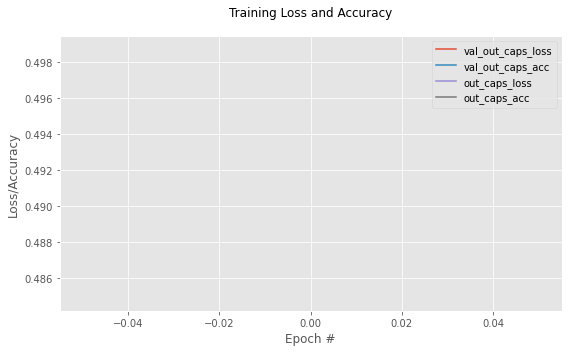

In [0]:
_, _ = CapsTest([5,5], frac=40, bs=BATCH_SIZE, epochs=15)

Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 38s 4ms/step - loss: 0.4016 - out_caps_loss: 0.4016 - out_recon_loss: 0.0752 - out_caps_acc: 0.5140 - out_recon_acc: 0.1719 - val_loss: 0.4045 - val_out_caps_loss: 0.4044 - val_out_recon_loss: 0.0660 - val_out_caps_acc: 0.5060 - val_out_recon_acc: 0.1999
Epoch 2/15
8928/8928 [==============================] - 36s 4ms/step - loss: 0.2710 - out_caps_loss: 0.2710 - out_recon_loss: 0.0397 - out_caps_acc: 0.5094 - out_recon_acc: 0.2017 - val_loss: 0.2115 - val_out_caps_loss: 0.2115 - val_out_recon_loss: 0.0294 - val_out_caps_acc: 0.5585 - val_out_recon_acc: 0.2016
Epoch 3/15
8928/8928 [==============================] - 36s 4ms/step - loss: 0.2059 - out_caps_loss: 0.2059 - out_recon_loss: 0.0297 - out_caps_acc: 0.5917 - out_recon_acc: 0.2016 - val_loss: 0.1938 - val_out_caps_loss: 0.1938 - val_out_recon_loss: 0.0291 - val_out_caps_acc: 0.6270 - val_out_recon_acc: 0.2015
Epoch 4/15
8928/8928

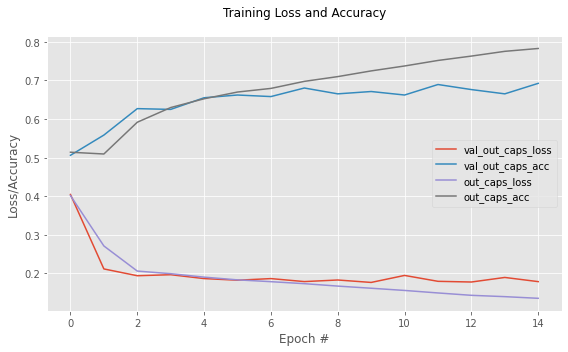

In [0]:
_, _ = CapsTest([7,7], frac=40, bs=BATCH_SIZE, epochs=15)

In [0]:
_, _ = CapsTest([9,9], frac=40, bs=BATCH_SIZE, epochs=15)

Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 58s 6ms/step - loss: 0.4043 - out_caps_loss: 0.4043 - out_recon_loss: 0.0758 - out_caps_acc: 0.4988 - out_recon_acc: 0.1735 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0690 - val_out_caps_acc: 0.4849 - val_out_recon_acc: 0.2022
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 58s 6ms/step - loss: 0.4057 - out_caps_loss: 0.4056 - out_recon_loss: 0.0741 - out_caps_acc: 0.4996 - out_recon_acc: 0.1712 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0584 - val_out_caps_acc: 0.4849 - val_out_recon_acc: 0.2005
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 58s 6ms/step - loss: 0.4054 - out_caps_loss: 0.4054 - out_recon_loss: 0.0749 - out_caps_acc: 0.5002 - out_recon_acc: 0.1724 - val_loss: 0.4050 - val_out_caps_loss: 0.4049 - val_out_

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 41s 5ms/step - loss: 0.4052 - out_caps_loss: 0.4052 - out_recon_loss: 0.0758 - out_caps_acc: 0.4976 - out_recon_acc: 0.1710 - val_loss: 0.4049 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0656 - val_out_caps_acc: 0

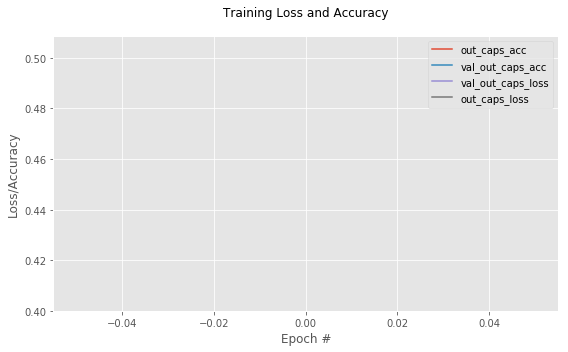

In [0]:
_, _ = CapsTest([11,11], frac=40, bs=BATCH_SIZE, epochs=15)

Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 54s 6ms/step - loss: 0.4043 - out_caps_loss: 0.4042 - out_recon_loss: 0.0749 - out_caps_acc: 0.5074 - out_recon_acc: 0.1729 - val_loss: 0.4049 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0636 - val_out_caps_acc: 0.5030 - val_out_recon_acc: 0.2029
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 54s 6ms/step - loss: 0.4049 - out_caps_loss: 0.4049 - out_recon_loss: 0.0405 - out_caps_acc: 0.4983 - out_recon_acc: 0.2019 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0303 - val_out_caps_acc: 0.4970 - val_out_recon_acc: 0.2029
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 54s 6ms/step - loss: 0.4049 - out_caps_loss: 0.4049 - out_recon_loss: 0.0306 - out_caps_acc: 0.4982 - out_recon_acc: 0.2023 - val_loss: 0.4050 - val_out_caps_loss: 0.4049 - val_out_

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


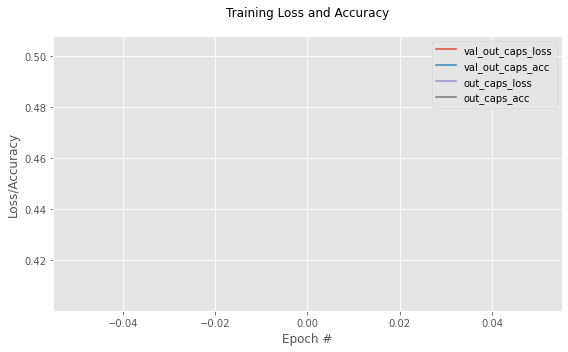

In [0]:
_, _ = CapsTest([13,13], frac=40, bs=BATCH_SIZE, epochs=15)

### 8.2 Test various different kernel sizes in layer 1 & 2 
[5,7], [5,9], [5,11], [7,9]

In [0]:
_, _ = CapsTest([5,7], frac=40, bs=BATCH_SIZE, epochs=15)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 77s 9ms/step - loss: 0.4059 - out_caps_loss: 0.4059 - out_recon_loss: 0.0759 - out_caps_acc: 0.4984 - out_recon_acc: 0.1726 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0671 - val_out_caps_acc: 0

In [0]:
_, _ = CapsTest([5,9], frac=40, bs=BATCH_SIZE, epochs=15)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 73s 8ms/step - loss: 0.2302 - out_caps_loss: 0.2301 - out_recon_loss: 0.0768 - out_caps_acc: 0.5509 - out_recon_acc: 0.1770 - val_loss: 0.2311 - val_out_caps_loss: 0.2310 - val_out_recon_loss: 0.0721 - val_out_caps_acc: 0

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images



W0322 17:12:37.398641 140110653511552 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0322 17:12:37.405283 140110653511552 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0322 17:12:37.411305 140110653511552 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0322 17:12:37.548597 140110653511552 deprecation.py:506] From <ipython-input-10-8daadbc5443a>:132: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))


W0322 17:12:37.636693 140110653511552 variables.py:2627] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.
W0322 17:12:37.747494 140110653511552 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0322 17:12:37.973892 140110653511552 deprecation.py:323] From /tensorflow-1.15.0/python2.7/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0322 17:12:38.662956 140110653511552 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W03

Train on 8928 samples, validate on 992 samples
Epoch 1/15


W0322 17:12:39.178720 140110653511552 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0322 17:12:39.180152 140110653511552 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0322 17:12:39.368820 140110653511552 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



8928/8928 [==============================] - 57s 6ms/step - loss: 0.2306 - out_caps_loss: 0.2306 - out_recon_loss: 0.0769 - out_caps_acc: 0.5425 - out_recon_acc: 0.1780 - val_loss: 0.2110 - val_out_caps_loss: 0.2110 - val_out_recon_loss: 0.0724 - val_out_caps_acc: 0.5554 - val_out_recon_acc: 0.2013
Epoch 2/15
8928/8928 [==============================] - 43s 5ms/step - loss: 0.2022 - out_caps_loss: 0.2021 - out_recon_loss: 0.0462 - out_caps_acc: 0.6117 - out_recon_acc: 0.2030 - val_loss: 0.1944 - val_out_caps_loss: 0.1943 - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.6442 - val_out_recon_acc: 0.2035
Epoch 3/15
8928/8928 [==============================] - 43s 5ms/step - loss: 0.1910 - out_caps_loss: 0.1909 - out_recon_loss: 0.0303 - out_caps_acc: 0.6391 - out_recon_acc: 0.2035 - val_loss: 0.1896 - val_out_caps_loss: 0.1896 - val_out_recon_loss: 0.0300 - val_out_caps_acc: 0.6673 - val_out_recon_acc: 0.2039
Epoch 4/15
8928/8928 [==============================] - 43s 5ms/step - loss: 0

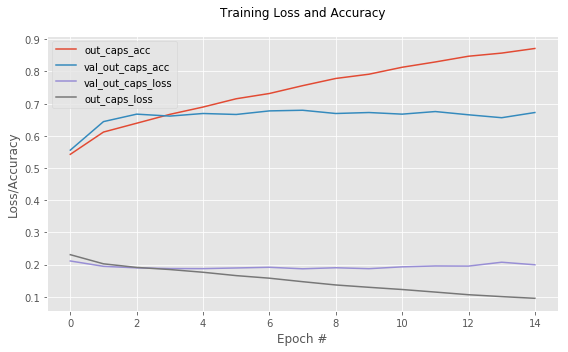

In [0]:
_, _ = CapsTest([5,11], frac=40, bs=BATCH_SIZE, epochs=15)

In [0]:
_, _ = CapsTest([7, 9], frac=40, bs=BATCH_SIZE, epochs=15)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 51s 6ms/step - loss: 0.2302 - out_caps_loss: 0.2302 - out_recon_loss: 0.0764 - out_caps_acc: 0.5286 - out_recon_acc: 0.1772 - val_loss: 0.2096 - val_out_caps_loss: 0.2096 - val_out_recon_loss: 0.0698 - val_out_caps_acc: 0

### 8.3 Test various different kernel sizes in layer 1 & 2 
[7,11], [7,13], [9,11], [9, 13]

In [0]:
_, _ = CapsTest([7, 11], frac=40, bs=BATCH_SIZE, epochs=15)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 53s 6ms/step - loss: 0.4035 - out_caps_loss: 0.4035 - out_recon_loss: 0.0762 - out_caps_acc: 0.5007 - out_recon_acc: 0.1716 - val_loss: 0.4048 - val_out_caps_loss: 0.4047 - val_out_recon_loss: 0.0680 - val_out_caps_acc: 0

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images



W0322 13:47:07.660892 140101368891264 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0322 13:47:07.666682 140101368891264 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0322 13:47:07.672363 140101368891264 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0322 13:47:07.773966 140101368891264 deprecation.py:506] From <ipython-input-13-8daadbc5443a>:132: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead
W0322 13:47:07.84638

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))


W0322 13:47:07.939882 140101368891264 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0322 13:47:08.101705 140101368891264 deprecation.py:323] From /tensorflow-1.15.0/python2.7/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0322 13:47:08.518929 140101368891264 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0322 13:47:08.739855 140101368891264 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign inste

Train on 8928 samples, validate on 992 samples
Epoch 1/15


W0322 13:47:09.092789 140101368891264 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0322 13:47:09.093857 140101368891264 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0322 13:47:09.250571 140101368891264 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



8928/8928 [==============================] - 77s 9ms/step - loss: 0.2342 - out_caps_loss: 0.2342 - out_recon_loss: 0.0763 - out_caps_acc: 0.5068 - out_recon_acc: 0.1757 - val_loss: 0.2143 - val_out_caps_loss: 0.2143 - val_out_recon_loss: 0.0689 - val_out_caps_acc: 0.4940 - val_out_recon_acc: 0.2011
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 64s 7ms/step - loss: 0.2145 - out_caps_loss: 0.2145 - out_recon_loss: 0.0412 - out_caps_acc: 0.5570 - out_recon_acc: 0.2034 - val_loss: 0.2089 - val_out_caps_loss: 0.2089 - val_out_recon_loss: 0.0303 - val_out_caps_acc: 0.5504 - val_out_recon_acc: 0.2038
Epoch 2/15
8928/8928 [==============================] - 64s 7ms/step - loss: 0.2008 - out_caps_loss: 0.2008 - out_recon_loss: 0.0303 - out_caps_acc: 0.6123 - out_recon_acc: 0.2035 - val_loss: 0.1965 - val_out_caps_loss: 0.1965 - val_out_recon_loss: 0.0301 - val_out_caps_acc: 0.6149 - val_out_recon_acc: 0.2030
Epoch 3/15
8928/8928 [=========

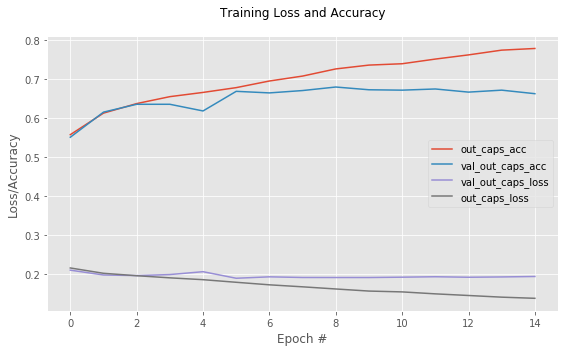

In [0]:
_, _ = CapsTest([7,13], frac=40, bs=BATCH_SIZE, epochs=15)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 59s 7ms/step - loss: 0.4046 - out_caps_loss: 0.4045 - out_recon_loss: 0.0752 - out_caps_acc: 0.5012 - out_recon_acc: 0.1741 - val_loss: 0.4047 - val_out_caps_loss: 0.4046 - val_out_recon_loss: 0.0628 - val_out_caps_acc: 0

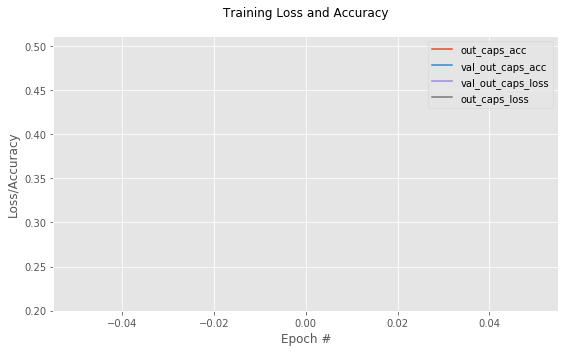

In [0]:
_, _ = CapsTest([9,11], frac=40, bs=BATCH_SIZE, epochs=15)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 8928 samples, validate on 992 samples
Epoch 1/15
8928/8928 [==============================] - 61s 7ms/step - loss: 0.4049 - out_caps_loss: 0.4049 - out_recon_loss: 0.0762 - out_caps_acc: 0.5043 - out_recon_acc: 0.1706 - val_loss: 0.4050 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0682 - val_out_caps_acc: 0

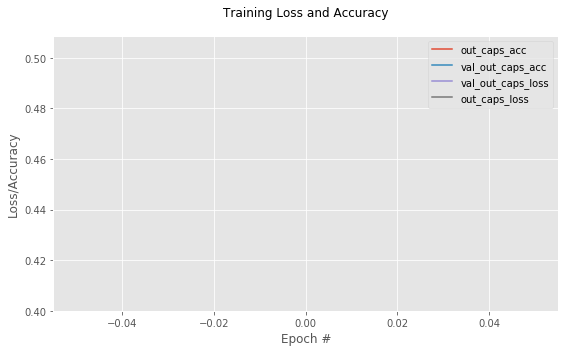

In [0]:
_, _ = CapsTest([9,13], frac=40, bs=BATCH_SIZE, epochs=15)

##9 Test of selected kernels on 60% of available training data
Use more data and epochs to see which kernels look the most promising.

Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 90s 7ms/step - loss: 0.4046 - out_caps_loss: 0.4046 - out_recon_loss: 0.0644 - out_caps_acc: 0.5045 - out_recon_acc: 0.1827 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2023
Epoch 2/30
13392/13392 [==============================] - 83s 6ms/step - loss: 0.4049 - out_caps_loss: 0.4049 - out_recon_loss: 0.0300 - out_caps_acc: 0.4981 - out_recon_acc: 0.2012 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0298 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2022
Epoch 00002: early stopping
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 85s 6ms/step - loss: 0.4050 - out_caps_loss: 0.4050 - out_recon_loss: 0.0305 - out_caps_acc: 0.4987 - out_recon_acc: 0.2014 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_los

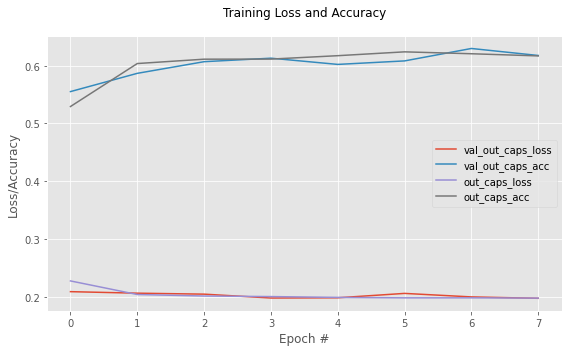


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.196    | 0.625    | 0.617     | 0.656    | 0.636   


In [0]:
(model, scores), hist = CapsTest([5,5], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_5.5_frac60.png")
showScores(scores)

In [0]:
(model, scores), hist = CapsTest([5,7], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_5.7_frac60.png")
showScores(scores)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 100s 7ms/step - loss: 0.2473 - out_caps_loss: 0.2472 - out_recon_loss: 0.0779 - out_caps_acc: 0.5406 - out_recon_acc: 0.1430 - val_loss: 0.2104 - val_out_caps_loss: 0.2104 - val_out_recon_loss: 0.0768 - val_out_caps_a


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.143    | 0.786    | 0.800     | 0.763    | 0.781   





Instructions for updating:
dim is deprecated, use axis instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 13392 samples, validate on 1488 samples
Epoch 1/30




13392/13392 [==============================] - 72s 5ms/step - loss: 0.2182 - out_caps_loss: 0.2182 - out_recon_loss: 0.0672 - out_caps_acc: 0.5636 - out_recon_acc: 0.1851 - val_loss: 0.2001 - val_out_caps_loss: 0.2001 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.6149 - val_out_recon_acc: 0.2019
Epoch 2/30
13392/13392 [==============================] - 59s 4ms/step - loss: 0.1931 - out_caps_loss: 0.1931 - out_recon_loss: 0.0299 - out_caps_acc: 0.6409 - out_recon_acc: 0.2015 - val_loss: 0.1890 - val_out_caps_loss: 0.1890 - val_out_recon_loss: 0.0296 - val_out_caps_acc: 0.6640 - val_out_recon_acc: 0.2028
Epoch 3/30
13392/13392 [==============================] - 58s 4ms/step - loss: 0.1857 - out_caps_loss: 0.1857 - out_recon_loss: 0.0296 - out_caps_acc: 0.6644

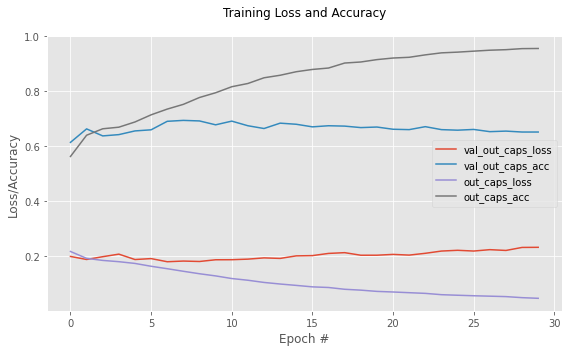


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.236    | 0.655    | 0.648     | 0.679    | 0.663   


In [0]:
(model, scores), hist = CapsTest([5,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_5.9_frac60.png")
showScores(scores)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 69s 5ms/step - loss: 0.4054 - out_caps_loss: 0.4054 - out_recon_loss: 0.0781 - out_caps_acc: 0.5022 - out_recon_acc: 0.1390 - val_loss: 0.4050 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0774 - val_out_caps_ac

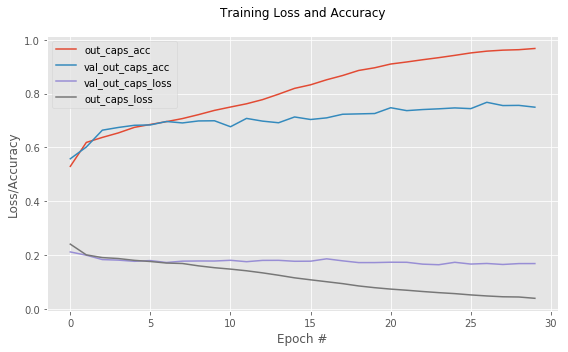


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.166    | 0.751    | 0.757     | 0.740    | 0.749   


In [0]:
(model, scores), hist = CapsTest([5,11], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_5.11_frac60.png")
showScores(scores)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 81s 6ms/step - loss: 0.2439 - out_caps_loss: 0.2439 - out_recon_loss: 0.0779 - out_caps_acc: 0.5171 - out_recon_acc: 0.1442 - val_loss: 0.2129 - val_out_caps_loss: 0.2128 - val_out_recon_loss: 0.0768 - val_out_caps_ac

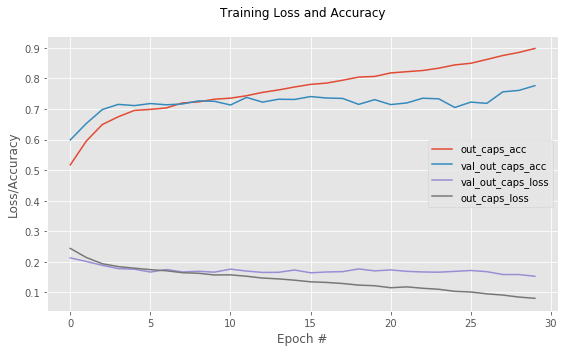


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.163    | 0.741    | 0.716     | 0.800    | 0.756   


In [0]:
(model, scores), hist = CapsTest([7,11], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_7.11_frac60.png")
showScores(scores)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 87s 6ms/step - loss: 0.4067 - out_caps_loss: 0.4067 - out_recon_loss: 0.0779 - out_caps_acc: 0.4993 - out_recon_acc: 0.1379 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0766 - val_out_caps_ac

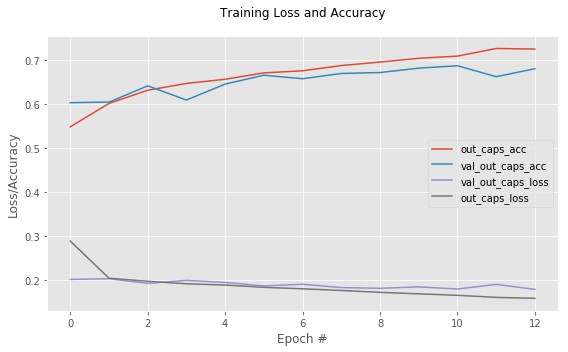


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.183    | 0.684    | 0.691     | 0.665    | 0.678   


In [0]:
(model, scores), hist = CapsTest([7,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_7.9_frac60.png")
showScores(scores)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 67s 5ms/step - loss: 0.4069 - out_caps_loss: 0.4069 - out_recon_loss: 0.0781 - out_caps_acc: 0.5034 - out_recon_acc: 0.1379 - val_loss: 0.4049 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0776 - val_out_caps_ac

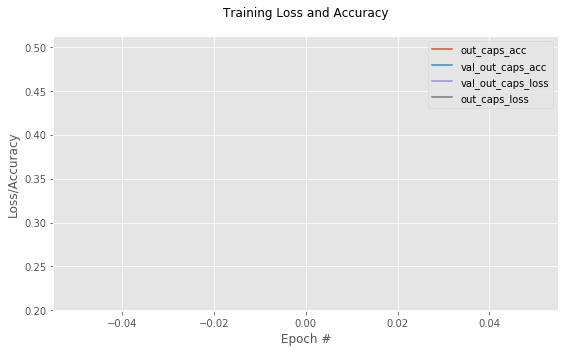


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.214    | 0.500    | 0.500     | 1.000    | 0.667   


In [0]:
(model, scores), hist = CapsTest([9,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_9.9_frac60.png")
showScores(scores)

##10 Test of selected kernels on all of available training data

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 132s 6ms/step - loss: 0.2284 - out_caps_loss: 0.2284 - out_recon_loss: 0.0775 - out_caps_acc: 0.5466 - out_recon_acc: 0.1612 - val_loss: 0.2072 - val_out_caps_loss: 0.2072 - val_out_recon_loss: 0.0760 - val_out_caps_a

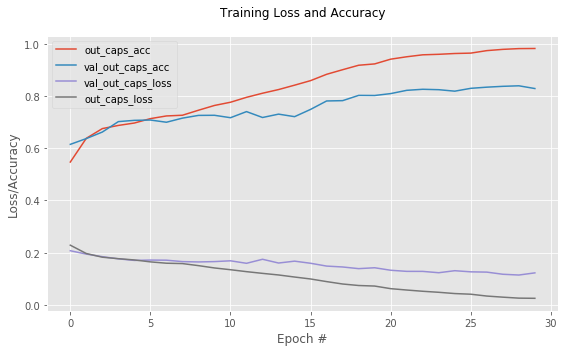


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.121    | 0.831    | 0.798     | 0.885    | 0.839   


In [0]:
(model, scores), hist = CapsTest([5,7], frac=100, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_5.7_frac100.png")
showScores(scores)




Instructions for updating:
dim is deprecated, use axis instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 22321 samples, validate on 2481 samples
Epoch 1/30




22321/22321 [==============================] - 126s 6ms/step - loss: 0.2095 - out_caps_loss: 0.2094 - out_recon_loss: 0.0526 - out_caps_acc: 0.5898 - out_recon_acc: 0.1918 - val_loss: 0.1952 - val_out_caps_loss: 0.1952 - val_out_recon_loss: 0.0291 - val_out_caps_acc: 0.6268 - val_out_recon_acc: 0.2013
Epoch 2/30
22321/22321 [==============================] - 111s 5ms/step - loss: 0.1876 - out_caps_loss: 0.1876 - out_recon_loss: 0.0296 - out_caps_acc: 0.6624 - out_recon_acc: 0.2017 - val_loss: 0.1861 - val_out_caps_loss: 0.1861 - val_out_recon_loss: 0.0289 - val_out_caps_acc: 0.6727 - val_out_recon_acc: 0.2019
Epoch 3/30
22321/22321 [==============================] - 111s 5ms/step - loss: 0.1789 - out_caps_loss: 0.1789 - out_recon_loss: 0.0294 - out_caps_acc: 0.6

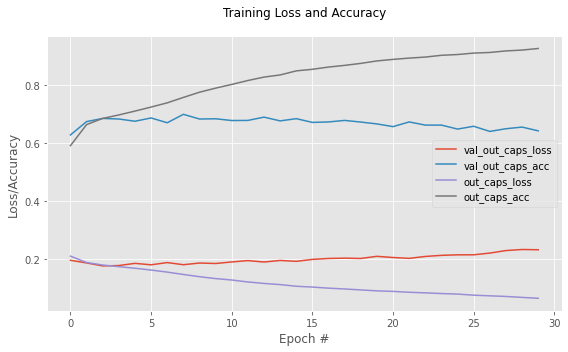


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.226    | 0.660    | 0.664     | 0.645    | 0.655   


In [0]:
(model, scores), hist = CapsTest([5,9], frac=100, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_5.9_frac100.png")
showScores(scores)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images



W0324 07:51:39.229861 140513968605056 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0324 07:51:39.237332 140513968605056 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0324 07:51:39.244052 140513968605056 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0324 07:51:39.346462 140513968605056 deprecation.py:506] From <ipython-input-16-8daadbc5443a>:132: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))


W0324 07:51:39.427962 140513968605056 variables.py:2627] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.
W0324 07:51:39.515898 140513968605056 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0324 07:51:39.683923 140513968605056 deprecation.py:323] From /tensorflow-1.15.0/python2.7/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0324 07:51:40.139878 140513968605056 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W03

Train on 22321 samples, validate on 2481 samples
Epoch 1/30


W0324 07:51:40.564330 140513968605056 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0324 07:51:40.565809 140513968605056 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0324 07:51:40.839416 140513968605056 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



22321/22321 [==============================] - 91s 4ms/step - loss: 0.2627 - out_caps_loss: 0.2627 - out_recon_loss: 0.0775 - out_caps_acc: 0.5234 - out_recon_acc: 0.1631 - val_loss: 0.2178 - val_out_caps_loss: 0.2178 - val_out_recon_loss: 0.0754 - val_out_caps_acc: 0.5699 - val_out_recon_acc: 0.1947
Epoch 2/30
22321/22321 [==============================] - 77s 3ms/step - loss: 0.2075 - out_caps_loss: 0.2074 - out_recon_loss: 0.0712 - out_caps_acc: 0.6073 - out_recon_acc: 0.1994 - val_loss: 0.1998 - val_out_caps_loss: 0.1997 - val_out_recon_loss: 0.0589 - val_out_caps_acc: 0.6405 - val_out_recon_acc: 0.2004
Epoch 3/30
22321/22321 [==============================] - 77s 3ms/step - loss: 0.1915 - out_caps_loss: 0.1915 - out_recon_loss: 0.0381 - out_caps_acc: 0.6602 - out_recon_acc: 0.2017 - val_loss: 0.1712 - val_out_caps_loss: 0.1712 - val_out_recon_loss: 0.0297 - val_out_caps_acc: 0.7005 - val_out_recon_acc: 0.2011
Epoch 4/30
22321/22321 [==============================] - 77s 3ms/step -

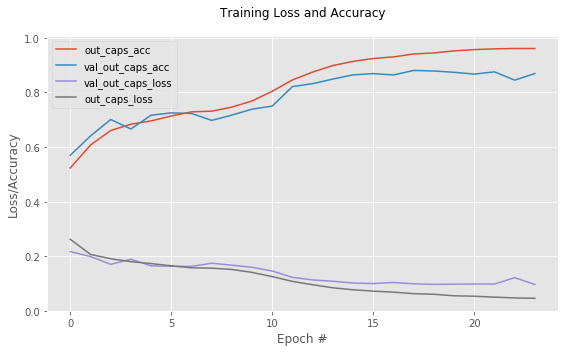


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.101    | 0.861    | 0.860     | 0.864    | 0.862   


In [0]:
(model, scores), hist = CapsTest([7,9], frac=100, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True,
                                 pltFile="6_CapsnetModel_7.9_frac100.png")
showScores(scores)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images



W0323 18:10:14.555890 139667730950016 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0323 18:10:14.562196 139667730950016 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0323 18:10:14.568123 139667730950016 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0323 18:10:14.674782 139667730950016 deprecation.py:506] From <ipython-input-10-8daadbc5443a>:132: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))


W0323 18:10:14.759963 139667730950016 variables.py:2627] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.
W0323 18:10:14.848323 139667730950016 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0323 18:10:15.021202 139667730950016 deprecation.py:323] From /tensorflow-1.15.0/python2.7/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0323 18:10:15.466228 139667730950016 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W03

Train on 22321 samples, validate on 2481 samples
Epoch 1/30


W0323 18:10:15.942589 139667730950016 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0323 18:10:15.944080 139667730950016 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0323 18:10:16.141562 139667730950016 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



22321/22321 [==============================] - 123s 5ms/step - loss: 0.2455 - out_caps_loss: 0.2454 - out_recon_loss: 0.0775 - out_caps_acc: 0.5274 - out_recon_acc: 0.1618 - val_loss: 0.2221 - val_out_caps_loss: 0.2221 - val_out_recon_loss: 0.0756 - val_out_caps_acc: 0.5002 - val_out_recon_acc: 0.1942
Epoch 2/30
22321/22321 [==============================] - 106s 5ms/step - loss: 0.2086 - out_caps_loss: 0.2085 - out_recon_loss: 0.0716 - out_caps_acc: 0.5836 - out_recon_acc: 0.1994 - val_loss: 0.1965 - val_out_caps_loss: 0.1964 - val_out_recon_loss: 0.0605 - val_out_caps_acc: 0.6546 - val_out_recon_acc: 0.2009
Epoch 3/30
22321/22321 [==============================] - 106s 5ms/step - loss: 0.1892 - out_caps_loss: 0.1892 - out_recon_loss: 0.0390 - out_caps_acc: 0.6534 - out_recon_acc: 0.2017 - val_loss: 0.1678 - val_out_caps_loss: 0.1678 - val_out_recon_loss: 0.0298 - val_out_caps_acc: 0.7166 - val_out_recon_acc: 0.2011
Epoch 4/30
22321/22321 [==============================] - 107s 5ms/st

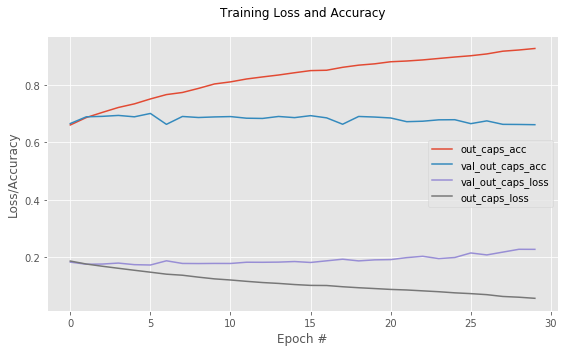


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.230    | 0.653    | 0.656     | 0.642    | 0.649   


In [0]:
(model, scores), hist = CapsTest([5,11], frac=100, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_5.11_frac100.png")
showScores(scores)

Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 54s 4ms/step - loss: 0.2253 - out_caps_loss: 0.2253 - out_recon_loss: 0.0691 - out_caps_acc: 0.5293 - out_recon_acc: 0.1863 - val_loss: 0.2063 - val_out_caps_loss: 0.2062 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.5995 - val_out_recon_acc: 0.2025
Epoch 2/30
13392/13392 [==============================] - 51s 4ms/step - loss: 0.2025 - out_caps_loss: 0.2025 - out_recon_loss: 0.0301 - out_caps_acc: 0.6134 - out_recon_acc: 0.2015 - val_loss: 0.2005 - val_out_caps_loss: 0.2005 - val_out_recon_loss: 0.0296 - val_out_caps_acc: 0.6290 - val_out_recon_acc: 0.2029
Epoch 3/30
13392/13392 [==============================] - 51s 4ms/step - loss: 0.1947 - out_caps_loss: 0.1947 - out_recon_loss: 0.0296 - out_caps_acc: 0.6445 - out_recon_acc: 0.2015 - val_loss: 0.1902 - val_out_caps_loss: 0.1902 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.6519 - val_out_recon_acc: 0.2015
Epoch 4/30
1

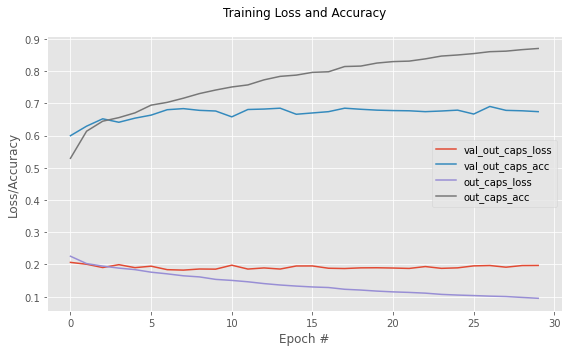


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.207    | 0.651    | 0.639     | 0.693    | 0.665   


In [0]:
(model, scores), hist = CapsTest([7,11], frac=100, bs=BATCH_SIZE, epochs=EPOCHS, 
                                 plot = True, 
                                 pltFile="6_CapsnetModel_7.11_frac100.png")
showScores(scores)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/gray//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/gray//Uninfected
Completed loading 13779 (of 13779) images

('Training data set size is', (22321, 44, 44, 1), (22321,))
('Validation data set size is', (2481, 44, 44, 1), (2481,))
('Test data data set size is', (2756, 44, 44, 1), (2756,))
('Training data labels and counts are', array([0, 1]), array([11161, 11160]))
('Validation data labels and counts are', array([0, 1]), array([1240, 1241]))
('Test data labels and counts are', array([0, 1]), array([1378, 1378]))
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 74s 3ms/step - loss: 0.4071 - out_caps_loss: 0.4070 - out_recon_loss: 0.0771 - out_caps_acc: 0.4999 - out_recon_acc: 0.1605 - val_loss: 0.4050 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0740 - val_out_caps_ac

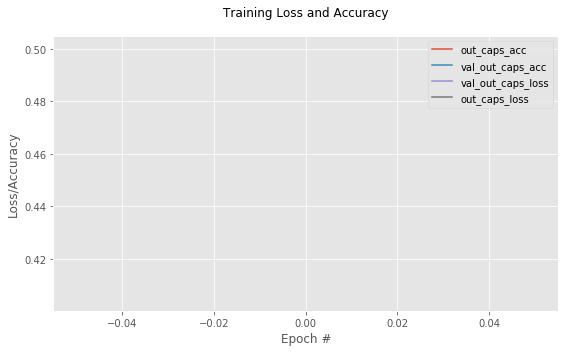


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.405    | 0.500    | 0.500     | 1.000    | 0.667   


In [0]:
(model, scores), hist = CapsTest([9,9], frac=100, bs=BATCH_SIZE, epochs=EPOCHS,  
                                 plot = True, 
                                 pltFile="6_CapsnetModel_9.9_frac100.png")
showScores(scores)

## 11 Check which kernel works best with modified filters
64 filters in first layer and 64 (8 capsules) in second

In [0]:
BATCH_SIZE=32

-------------------------------------
Testing with kernel kernel sizes 5/5
-------------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 23s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0756 - out_caps_acc: 0.4976 - out_recon_acc: 0.2019 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0696 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2030
Epoch 2/30
13392/13392 [==============================] - 21s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0490 - out_caps_acc: 0.4981 - out_recon_acc: 0.2015 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2021
Epoch 00002: early stopping
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 24s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0307 - out_caps_acc: 0.4981 - out_r

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


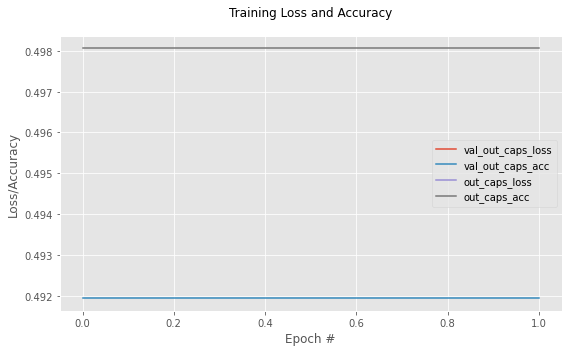


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------------
Testing with kernel kernel sizes 5/7
-------------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 25s 2ms/step - loss: 0.4033 - out_caps_loss: 0.4033 - out_recon_loss: 0.0657 - out_caps_acc: 0.4952 - out_recon_acc: 0.1823 - val_loss: 0.4044 - val_out_caps_loss: 0.4044 - val_out_recon_loss: 0.0313 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.2017
Epoch 2/30
13392/13392 [==============================] - 20s 1ms/step - loss: 0.2445 - out_caps_loss: 0.2445 - out_recon_loss: 0.0307 - out_caps_acc: 0.5496 - out_recon_acc: 0.2015 - val_loss: 0.1962 - val_out_caps_loss: 0.1962 - val_out_recon_loss: 0.0296 - val_out_caps_acc: 0.6384 - val_out_recon_acc: 0.2026
Epoch 3/30

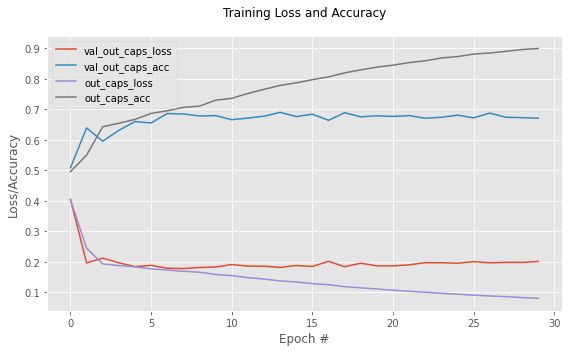


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.204    | 0.659    | 0.669     | 0.629    | 0.648   

-------------------------------------
Testing with kernel kernel sizes 5/9
-------------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 24s 2ms/step - loss: 0.2654 - out_caps_loss: 0.2654 - out_recon_loss: 0.0707 - out_caps_acc: 0.5403 - out_recon_acc: 0.1830 - val_loss: 0.2010 - val_out_caps_loss: 0.2010 - val_out_recon_loss: 0.0381 - val_out_caps_acc: 0.6418 - val_out_recon_acc: 0.2027
Epoch 2/30
13392/13392 [==============================] - 19s 1ms/step - loss: 0.1954 - out_caps_loss: 0.1954 - out_recon_loss: 0.0303 - out_caps_acc: 0.6414 - out_recon_acc: 0.2015 - val_loss: 0.1846 - val_out_caps_loss: 0.1845 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.6640 - val_out_recon_acc: 0.2026
Epoch 3/30

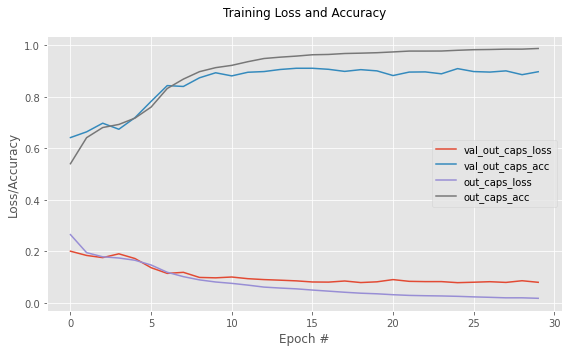


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.087    | 0.892    | 0.874     | 0.916    | 0.894   

-------------------------------------
Testing with kernel kernel sizes 7/9
-------------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 25s 2ms/step - loss: 0.4032 - out_caps_loss: 0.4032 - out_recon_loss: 0.0683 - out_caps_acc: 0.5078 - out_recon_acc: 0.1828 - val_loss: 0.4049 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0332 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2017
Epoch 2/30
13392/13392 [==============================] - 19s 1ms/step - loss: 0.4049 - out_caps_loss: 0.4049 - out_recon_loss: 0.0300 - out_caps_acc: 0.4981 - out_recon_acc: 0.2014 - val_loss: 0.4049 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2029
Epoch 0000

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


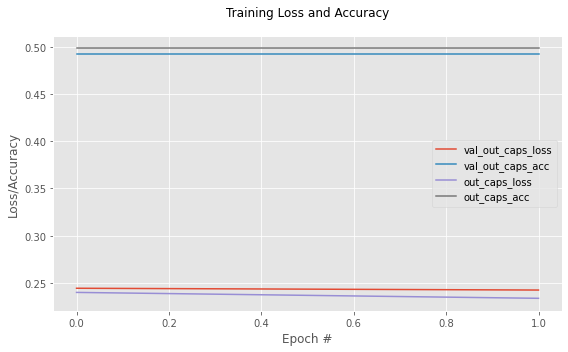


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.237    | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------------
Testing with kernel kernel sizes 9/9
-------------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 25s 2ms/step - loss: 0.4004 - out_caps_loss: 0.4003 - out_recon_loss: 0.0637 - out_caps_acc: 0.4941 - out_recon_acc: 0.1824 - val_loss: 0.4046 - val_out_caps_loss: 0.4045 - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.2018
Epoch 2/30
13392/13392 [==============================] - 17s 1ms/step - loss: 0.4044 - out_caps_loss: 0.4044 - out_recon_loss: 0.0298 - out_caps_acc: 0.5019 - out_recon_acc: 0.2016 - val_loss: 0.4046 - val_out_caps_loss: 0.4046 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.2028
Epoch 0000

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


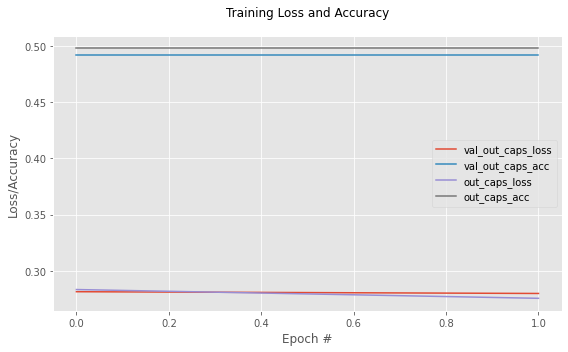


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.277    | 0.500    | 0.000     | 0.000    | 0.000   



In [0]:
klist=[[5,5],
       [5,7], 
       [5,9],
       [7,9],
       [9,9]]

for k_size in klist:
    print("-------------------------------------")
    print("Testing with kernel kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------------")
    (model, scores), hist = CapsTest(k_size, frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=[64,64],
                                    pltFile="6_CapsnetModel_{}.{}_f64.64.png".format(k_size[0],k_size[1]))
    showScores(scores)
    print("")

##12 Search for Best Filter sizes

In [0]:
BATCH_SIZE=32

-------------------------------
Testing with filter sizes 32/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 36s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0754 - out_caps_acc: 0.4976 - out_recon_acc: 0.2032 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0690 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2037
Epoch 2/30
13392/13392 [==============================] - 33s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0482 - out_caps_acc: 0.4981 - out_recon_acc: 0.2021 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2020
Epoch 00002: early stopping
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 36s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0306 - out_caps_acc: 0.4981 - out_recon_acc: 0.2017 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


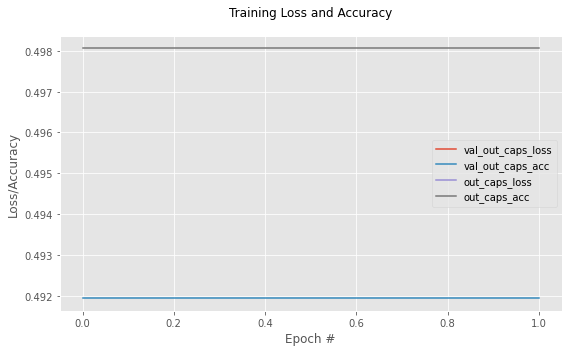


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 48/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 41s 3ms/step - loss: 0.2209 - out_caps_loss: 0.2208 - out_recon_loss: 0.0700 - out_caps_acc: 0.5581 - out_recon_acc: 0.1854 - val_loss: 0.1968 - val_out_caps_loss: 0.1968 - val_out_recon_loss: 0.0364 - val_out_caps_acc: 0.6626 - val_out_recon_acc: 0.2026
Epoch 2/30
13392/13392 [==============================] - 35s 3ms/step - loss: 0.1920 - out_caps_loss: 0.1919 - out_recon_loss: 0.0302 - out_caps_acc: 0.6511 - out_recon_acc: 0.2018 - val_loss: 0.1848 - val_out_caps_loss: 0.1848 - val_out_recon_loss: 0.0294 - val_out_caps_acc: 0.6599 - val_out_recon_acc: 0.2030
Epoch 3/30
13392/13392 [===


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.109    | 0.851    | 0.808     | 0.919    | 0.860   

-------------------------------
Testing with filter sizes 64/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 42s 3ms/step - loss: 0.2262 - out_caps_loss: 0.2262 - out_recon_loss: 0.0689 - out_caps_acc: 0.5547 - out_recon_acc: 0.1856 - val_loss: 0.1988 - val_out_caps_loss: 0.1988 - val_out_recon_loss: 0.0336 - val_out_caps_acc: 0.6465 - val_out_recon_acc: 0.2020
Epoch 2/30
13392/13392 [==============================] - 35s 3ms/step - loss: 0.1900 - out_caps_loss: 0.1900 - out_recon_loss: 0.0300 - out_caps_acc: 0.6555 - out_recon_acc: 0.2015 - val_loss: 0.1848 - val_out_caps_loss: 0.1848 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.6700 - val_out_recon_acc: 0.2027
Epoch 3/30
13392/13392 [===


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.079    | 0.901    | 0.887     | 0.918    | 0.902   

-------------------------------
Testing with filter sizes 32/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 62s 5ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0755 - out_caps_acc: 0.4979 - out_recon_acc: 0.2017 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0695 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2022
Epoch 2/30
13392/13392 [==============================] - 57s 4ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0488 - out_caps_acc: 0.4981 - out_recon_acc: 0.2014 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2023
Epoch 00002: early stopping
Train on 13392 samples

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


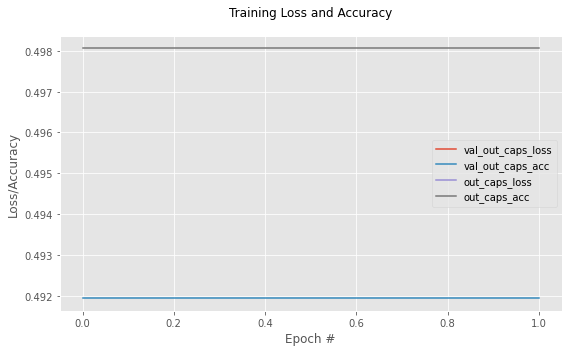


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 48/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 68s 5ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0754 - out_caps_acc: 0.4976 - out_recon_acc: 0.2025 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0691 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2032
Epoch 2/30
13392/13392 [==============================] - 59s 4ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0484 - out_caps_acc: 0.4981 - out_recon_acc: 0.2022 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2024
Epoch 00002: early stopping
Train on 13392 samples

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


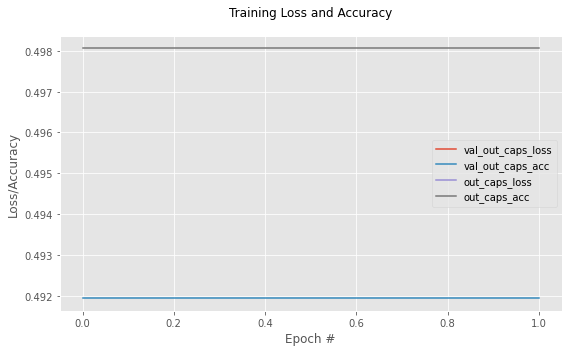


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 64/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 71s 5ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0754 - out_caps_acc: 0.4976 - out_recon_acc: 0.2020 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0690 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2028
Epoch 2/30
13392/13392 [==============================] - 60s 4ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0482 - out_caps_acc: 0.4981 - out_recon_acc: 0.2017 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2022
Epoch 00002: early stopping
Train on 13392 samples

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


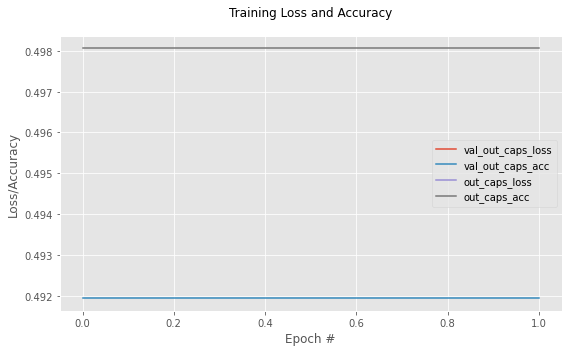


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 128/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 77s 6ms/step - loss: 0.4042 - out_caps_loss: 0.4041 - out_recon_loss: 0.0684 - out_caps_acc: 0.5062 - out_recon_acc: 0.1831 - val_loss: 0.4049 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0339 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2021
Epoch 2/30
13392/13392 [==============================] - 62s 5ms/step - loss: 0.4048 - out_caps_loss: 0.4048 - out_recon_loss: 0.0303 - out_caps_acc: 0.5052 - out_recon_acc: 0.2014 - val_loss: 0.4050 - val_out_caps_loss: 0.4050 - val_out_recon_loss: 0.0298 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.2021
Epoch 00002: early stoppi


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.199    | 0.622    | 0.615     | 0.656    | 0.635   



In [0]:
flist=[[32,64], 
       [48,64],
       [64,64],
       [32,128],
       [48,128],
       [64,128],
       [128,128]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([5,7], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    es=True,
                                    pltFile="6_CapsnetModel_5.7_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

-------------------------------
Testing with filter sizes 32/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 49s 4ms/step - loss: 0.3511 - out_caps_loss: 0.3510 - out_recon_loss: 0.0660 - out_caps_acc: 0.5122 - out_recon_acc: 0.1811 - val_loss: 0.2120 - val_out_caps_loss: 0.2120 - val_out_recon_loss: 0.0315 - val_out_caps_acc: 0.5921 - val_out_recon_acc: 0.2029
Epoch 2/30
13392/13392 [==============================] - 33s 2ms/step - loss: 0.2013 - out_caps_loss: 0.2013 - out_recon_loss: 0.0299 - out_caps_acc: 0.6196 - out_recon_acc: 0.2020 - val_loss: 0.1954 - val_out_caps_loss: 0.1954 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.6445 - val_out_recon_acc: 0.2032
Epoch 3/30
13392/13392 [==============================] - 32s 2ms/step - loss: 0.1815 - out_caps_loss: 0.1815 - out_recon_loss: 0.0295 - out_caps_acc: 0.6798 - out_recon_acc: 0.2020 - val_loss: 0.2139 - val_out_caps_loss: 0.2139 


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.076    | 0.913    | 0.916     | 0.909    | 0.913   

-------------------------------
Testing with filter sizes 48/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 51s 4ms/step - loss: 0.4040 - out_caps_loss: 0.4039 - out_recon_loss: 0.0659 - out_caps_acc: 0.5007 - out_recon_acc: 0.1831 - val_loss: 0.4043 - val_out_caps_loss: 0.4043 - val_out_recon_loss: 0.0359 - val_out_caps_acc: 0.5148 - val_out_recon_acc: 0.2025
Epoch 2/30
13392/13392 [==============================] - 34s 3ms/step - loss: 0.4040 - out_caps_loss: 0.4040 - out_recon_loss: 0.0302 - out_caps_acc: 0.4984 - out_recon_acc: 0.2013 - val_loss: 0.4046 - val_out_caps_loss: 0.4046 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2026
Epoch 00002: early stopping

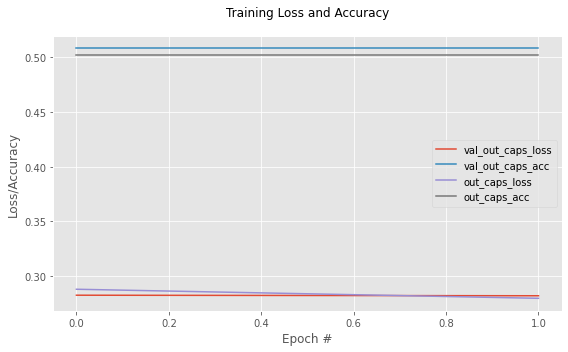


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.283    | 0.500    | 0.500     | 1.000    | 0.667   

-------------------------------
Testing with filter sizes 64/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 54s 4ms/step - loss: 0.2272 - out_caps_loss: 0.2271 - out_recon_loss: 0.0692 - out_caps_acc: 0.5565 - out_recon_acc: 0.1863 - val_loss: 0.2028 - val_out_caps_loss: 0.2028 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.6378 - val_out_recon_acc: 0.2025
Epoch 2/30
13392/13392 [==============================] - 34s 3ms/step - loss: 0.1942 - out_caps_loss: 0.1942 - out_recon_loss: 0.0301 - out_caps_acc: 0.6398 - out_recon_acc: 0.2015 - val_loss: 0.1852 - val_out_caps_loss: 0.1852 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.6660 - val_out_recon_acc: 0.2028
Epoch 3/30
13392/13392 [===


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.087    | 0.890    | 0.856     | 0.938    | 0.895   

-------------------------------
Testing with filter sizes 32/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 66s 5ms/step - loss: 0.4040 - out_caps_loss: 0.4040 - out_recon_loss: 0.0647 - out_caps_acc: 0.5028 - out_recon_acc: 0.1832 - val_loss: 0.4048 - val_out_caps_loss: 0.4048 - val_out_recon_loss: 0.0306 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.2023
Epoch 2/30
13392/13392 [==============================] - 45s 3ms/step - loss: 0.2995 - out_caps_loss: 0.2995 - out_recon_loss: 0.0298 - out_caps_acc: 0.5302 - out_recon_acc: 0.2016 - val_loss: 0.2034 - val_out_caps_loss: 0.2034 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.6122 - val_out_recon_acc: 0.2028
Epoch 3/30
13392/13392 [==

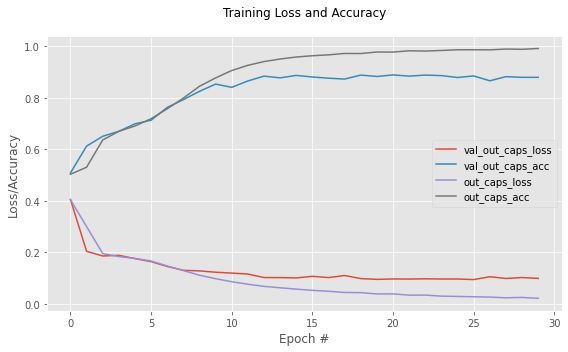


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.097    | 0.881    | 0.873     | 0.893    | 0.883   

-------------------------------
Testing with filter sizes 48/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 67s 5ms/step - loss: 0.2241 - out_caps_loss: 0.2241 - out_recon_loss: 0.0714 - out_caps_acc: 0.5576 - out_recon_acc: 0.1850 - val_loss: 0.1959 - val_out_caps_loss: 0.1959 - val_out_recon_loss: 0.0411 - val_out_caps_acc: 0.6465 - val_out_recon_acc: 0.2025
Epoch 2/30
13392/13392 [==============================] - 47s 3ms/step - loss: 0.1965 - out_caps_loss: 0.1965 - out_recon_loss: 0.0306 - out_caps_acc: 0.6404 - out_recon_acc: 0.2016 - val_loss: 0.1834 - val_out_caps_loss: 0.1834 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.6828 - val_out_recon_acc: 0.2030
Epoch 3/30
13392/13392 [==


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.087    | 0.888    | 0.868     | 0.916    | 0.891   

-------------------------------
Testing with filter sizes 64/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 69s 5ms/step - loss: 0.4048 - out_caps_loss: 0.4048 - out_recon_loss: 0.0655 - out_caps_acc: 0.4985 - out_recon_acc: 0.1817 - val_loss: 0.4049 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0309 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2023
Epoch 2/30
13392/13392 [==============================] - 48s 4ms/step - loss: 0.4049 - out_caps_loss: 0.4049 - out_recon_loss: 0.0298 - out_caps_acc: 0.4981 - out_recon_acc: 0.2017 - val_loss: 0.4046 - val_out_caps_loss: 0.4046 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2029
Epoch 00002: early stoppin


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.197    | 0.631    | 0.592     | 0.842    | 0.695   

-------------------------------
Testing with filter sizes 128/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 77s 6ms/step - loss: 0.3555 - out_caps_loss: 0.3555 - out_recon_loss: 0.0662 - out_caps_acc: 0.4971 - out_recon_acc: 0.1816 - val_loss: 0.2134 - val_out_caps_loss: 0.2134 - val_out_recon_loss: 0.0317 - val_out_caps_acc: 0.5397 - val_out_recon_acc: 0.2020
Epoch 2/30
13392/13392 [==============================] - 55s 4ms/step - loss: 0.2027 - out_caps_loss: 0.2027 - out_recon_loss: 0.0299 - out_caps_acc: 0.6057 - out_recon_acc: 0.2015 - val_loss: 0.1940 - val_out_caps_loss: 0.1940 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.6505 - val_out_recon_acc: 0.2029
Epoch 3/30
13392/13392 [=

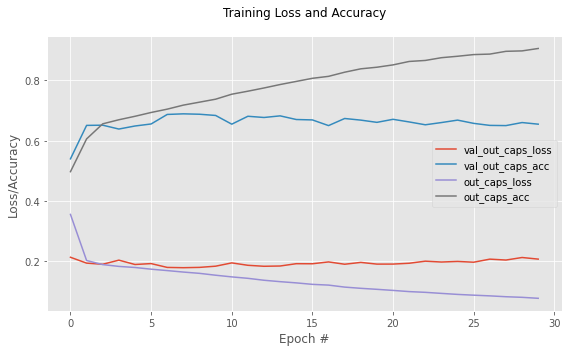


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.213    | 0.646    | 0.639     | 0.672    | 0.655   



In [0]:
flist=[[32,64], 
       [48,64],
       [64,64],
       [32,128],
       [48,128],
       [64,128],
       [128,128]]
       
for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([5,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    pltFile="6_CapsnetModel_5.9_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

-------------------------------
Testing with filter sizes 32/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 24s 2ms/step - loss: 0.2269 - out_caps_loss: 0.2269 - out_recon_loss: 0.0701 - out_caps_acc: 0.5218 - out_recon_acc: 0.1834 - val_loss: 0.2141 - val_out_caps_loss: 0.2141 - val_out_recon_loss: 0.0363 - val_out_caps_acc: 0.5880 - val_out_recon_acc: 0.2024
Epoch 2/30
13392/13392 [==============================] - 24s 2ms/step - loss: 0.2087 - out_caps_loss: 0.2087 - out_recon_loss: 0.0302 - out_caps_acc: 0.5889 - out_recon_acc: 0.2018 - val_loss: 0.2052 - val_out_caps_loss: 0.2051 - val_out_recon_loss: 0.0293 - val_out_caps_acc: 0.6230 - val_out_recon_acc: 0.2016
Epoch 3/30
13392/13392 [==============================] - 23s 2ms/step - loss: 0.1950 - out_caps_loss: 0.1950 - out_recon_loss: 0.0295 - out_caps_acc: 0.6466 - out_recon_acc: 0.2017 - val_loss: 0.1978 - val_out_caps_loss: 0.1978 

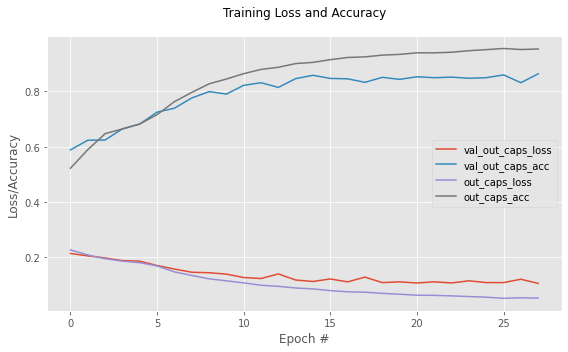


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.107    | 0.857    | 0.861     | 0.851    | 0.856   

-------------------------------
Testing with filter sizes 48/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 25s 2ms/step - loss: 0.2997 - out_caps_loss: 0.2997 - out_recon_loss: 0.0695 - out_caps_acc: 0.5043 - out_recon_acc: 0.1812 - val_loss: 0.2127 - val_out_caps_loss: 0.2126 - val_out_recon_loss: 0.0358 - val_out_caps_acc: 0.5397 - val_out_recon_acc: 0.2026
Epoch 2/30
13392/13392 [==============================] - 24s 2ms/step - loss: 0.2111 - out_caps_loss: 0.2111 - out_recon_loss: 0.0302 - out_caps_acc: 0.5694 - out_recon_acc: 0.2019 - val_loss: 0.2066 - val_out_caps_loss: 0.2066 - val_out_recon_loss: 0.0292 - val_out_caps_acc: 0.6344 - val_out_recon_acc: 0.2019
Epoch 3/30
13392/13392 [===

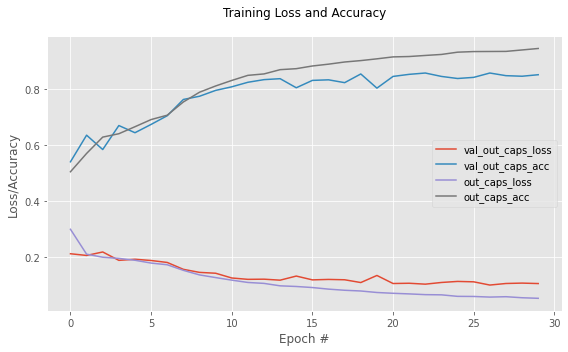


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.106    | 0.855    | 0.851     | 0.861    | 0.856   

-------------------------------
Testing with filter sizes 64/64
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 25s 2ms/step - loss: 0.3977 - out_caps_loss: 0.3977 - out_recon_loss: 0.0690 - out_caps_acc: 0.5099 - out_recon_acc: 0.1828 - val_loss: 0.4041 - val_out_caps_loss: 0.4041 - val_out_recon_loss: 0.0358 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2022
Epoch 2/30
13392/13392 [==============================] - 24s 2ms/step - loss: 0.2812 - out_caps_loss: 0.2811 - out_recon_loss: 0.0303 - out_caps_acc: 0.5137 - out_recon_acc: 0.2020 - val_loss: 0.2140 - val_out_caps_loss: 0.2140 - val_out_recon_loss: 0.0292 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.2021
Epoch 3/30
13392/13392 [===

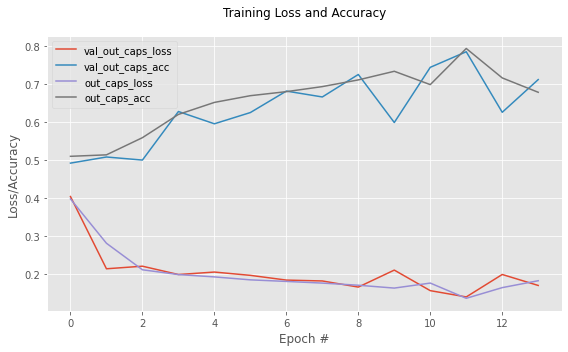


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.167    | 0.716    | 0.733     | 0.678    | 0.704   

-------------------------------
Testing with filter sizes 32/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 33s 2ms/step - loss: 0.4049 - out_caps_loss: 0.4049 - out_recon_loss: 0.0690 - out_caps_acc: 0.5098 - out_recon_acc: 0.1802 - val_loss: 0.4048 - val_out_caps_loss: 0.4048 - val_out_recon_loss: 0.0335 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.2022
Epoch 2/30
13392/13392 [==============================] - 32s 2ms/step - loss: 0.4045 - out_caps_loss: 0.4045 - out_recon_loss: 0.0309 - out_caps_acc: 0.5003 - out_recon_acc: 0.2022 - val_loss: 0.4049 - val_out_caps_loss: 0.4049 - val_out_recon_loss: 0.0298 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2025
Epoch 3/30
13392/13392 [==

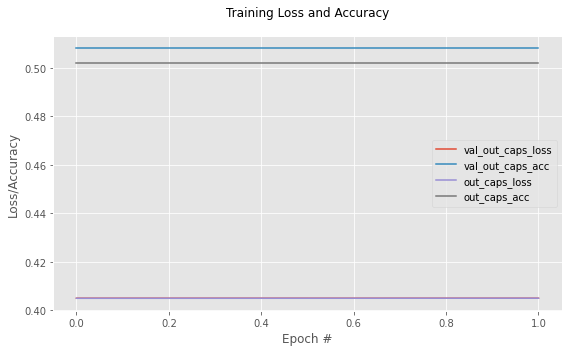


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.405    | 0.500    | 0.500     | 1.000    | 0.667   

-------------------------------
Testing with filter sizes 48/128
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 36s 3ms/step - loss: 0.2314 - out_caps_loss: 0.2314 - out_recon_loss: 0.0701 - out_caps_acc: 0.5423 - out_recon_acc: 0.1860 - val_loss: 0.2128 - val_out_caps_loss: 0.2128 - val_out_recon_loss: 0.0367 - val_out_caps_acc: 0.5806 - val_out_recon_acc: 0.2029
Epoch 2/30
13392/13392 [==============================] - 31s 2ms/step - loss: 0.2003 - out_caps_loss: 0.2003 - out_recon_loss: 0.0303 - out_caps_acc: 0.6160 - out_recon_acc: 0.2020 - val_loss: 0.2382 - val_out_caps_loss: 0.2382 - val_out_recon_loss: 0.0294 - val_out_caps_acc: 0.5491 - val_out_recon_acc: 0.2019
Epoch 3/30
13392/13392 [==

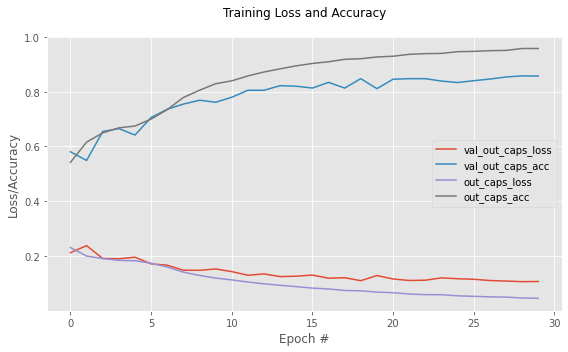


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.105    | 0.849    | 0.865     | 0.827    | 0.846   



In [0]:
flist=[[32,64], 
       [48,64],
       [64,64],
       [32,128],
       [48,128]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([9,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    es=True,
                                    pltFile="6_CapsnetModel_5.7_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

-------------------------------
Testing with filter sizes 8/16
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 49s 4ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0755 - out_caps_acc: 0.4976 - out_recon_acc: 0.2025 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0696 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2031
Epoch 2/30
13392/13392 [==============================] - 20s 1ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0490 - out_caps_acc: 0.4981 - out_recon_acc: 0.2025 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2021
Epoch 00002: early stopping
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 50s 4ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0307 - out_caps_acc: 0.4981 - out_recon_acc: 0.2020 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


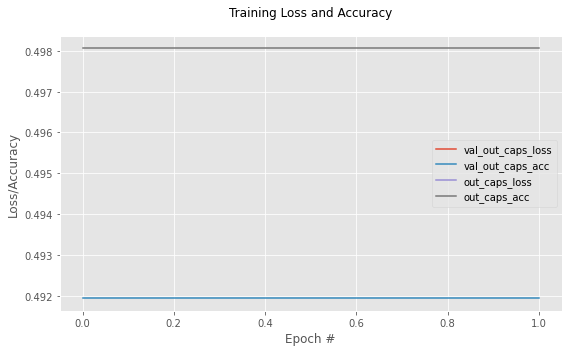


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 55s 4ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0754 - out_caps_acc: 0.4975 - out_recon_acc: 0.2025 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0690 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2032
Epoch 2/30
13392/13392 [==============================] - 22s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0481 - out_caps_acc: 0.4981 - out_recon_acc: 0.2021 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2019
Epoch 00002: early stopping
Train on 13392 samples,

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


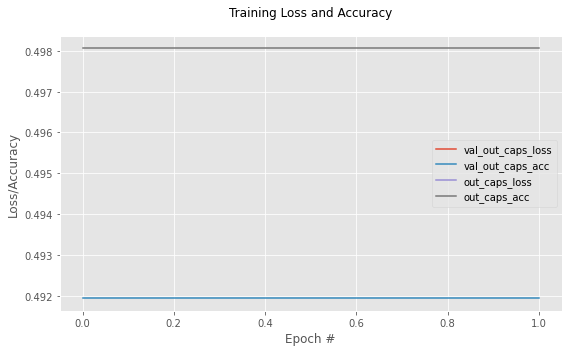


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 16/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 61s 5ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0755 - out_caps_acc: 0.4981 - out_recon_acc: 0.2024 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0694 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2029
Epoch 2/30
13392/13392 [==============================] - 26s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0488 - out_caps_acc: 0.4981 - out_recon_acc: 0.2025 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2022
Epoch 00002: early stopping
Train on 13392 samples,

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


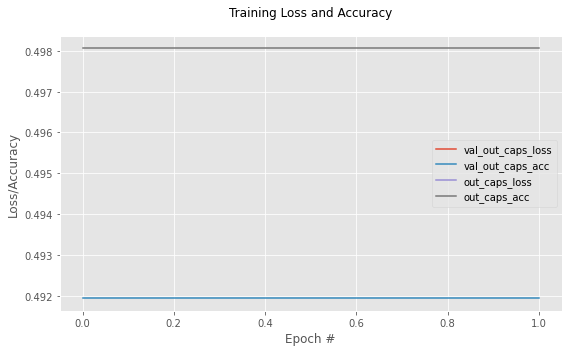


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 24/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 63s 5ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0754 - out_caps_acc: 0.4975 - out_recon_acc: 0.2029 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0690 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2031
Epoch 2/30
13392/13392 [==============================] - 25s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0481 - out_caps_acc: 0.4981 - out_recon_acc: 0.2025 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2022
Epoch 00002: early stopping
Train on 13392 samples,

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


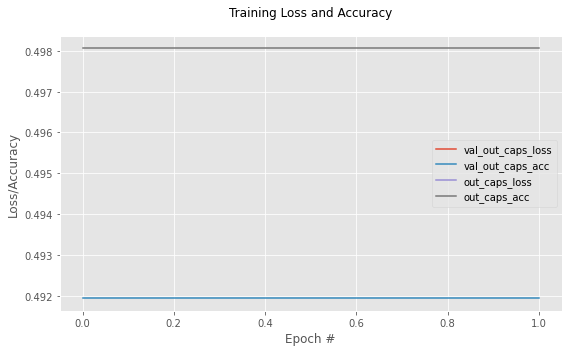


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   



In [0]:
flist=[[8,16],
       [16,32],
       [16,48],
       [24,48]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([5,7], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    es=True,
                                    pltFile="6_CapsnetModel_5.7_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

-------------------------------
Testing with filter sizes 8/16
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 47s 4ms/step - loss: 0.2044 - out_caps_loss: 0.2044 - out_recon_loss: 0.0697 - out_caps_acc: 0.6024 - out_recon_acc: 0.1850 - val_loss: 0.1752 - val_out_caps_loss: 0.1752 - val_out_recon_loss: 0.0350 - val_out_caps_acc: 0.6835 - val_out_recon_acc: 0.2019
Epoch 2/30
13392/13392 [==============================] - 19s 1ms/step - loss: 0.1691 - out_caps_loss: 0.1691 - out_recon_loss: 0.0302 - out_caps_acc: 0.7203 - out_recon_acc: 0.2017 - val_loss: 0.1570 - val_out_caps_loss: 0.1569 - val_out_recon_loss: 0.0292 - val_out_caps_acc: 0.7372 - val_out_recon_acc: 0.2016
Epoch 3/30
13392/13392 [==============================] - 20s 1ms/step - loss: 0.1395 - out_caps_loss: 0.1395 - out_recon_loss: 0.0295 - out_caps_acc: 0.7884 - out_recon_acc: 0.2017 - val_loss: 0.1560 - val_out_caps_loss: 0.1560 -


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.121    | 0.824    | 0.752     | 0.968    | 0.846   

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 51s 4ms/step - loss: 0.2212 - out_caps_loss: 0.2212 - out_recon_loss: 0.0686 - out_caps_acc: 0.5716 - out_recon_acc: 0.1838 - val_loss: 0.1944 - val_out_caps_loss: 0.1943 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.6673 - val_out_recon_acc: 0.2022
Epoch 2/30
13392/13392 [==============================] - 22s 2ms/step - loss: 0.1737 - out_caps_loss: 0.1737 - out_recon_loss: 0.0301 - out_caps_acc: 0.7045 - out_recon_acc: 0.2015 - val_loss: 0.1526 - val_out_caps_loss: 0.1526 - val_out_recon_loss: 0.0293 - val_out_caps_acc: 0.7574 - val_out_recon_acc: 0.2014
Epoch 3/30
13392/13392 [===

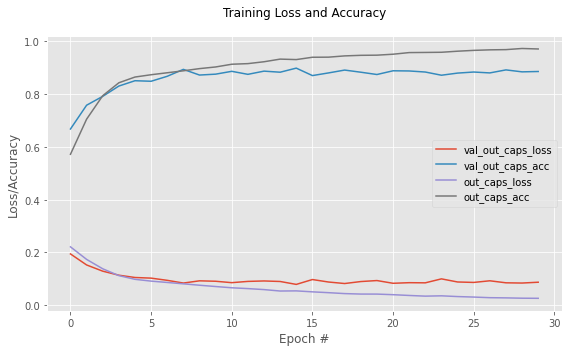


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.091    | 0.877    | 0.885     | 0.866    | 0.875   

-------------------------------
Testing with filter sizes 16/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 53s 4ms/step - loss: 0.2218 - out_caps_loss: 0.2218 - out_recon_loss: 0.0686 - out_caps_acc: 0.5668 - out_recon_acc: 0.1847 - val_loss: 0.2096 - val_out_caps_loss: 0.2096 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.6398 - val_out_recon_acc: 0.2022
Epoch 2/30
13392/13392 [==============================] - 24s 2ms/step - loss: 0.1902 - out_caps_loss: 0.1902 - out_recon_loss: 0.0300 - out_caps_acc: 0.6613 - out_recon_acc: 0.2018 - val_loss: 0.1752 - val_out_caps_loss: 0.1752 - val_out_recon_loss: 0.0292 - val_out_caps_acc: 0.7070 - val_out_recon_acc: 0.2020
Epoch 3/30
13392/13392 [===

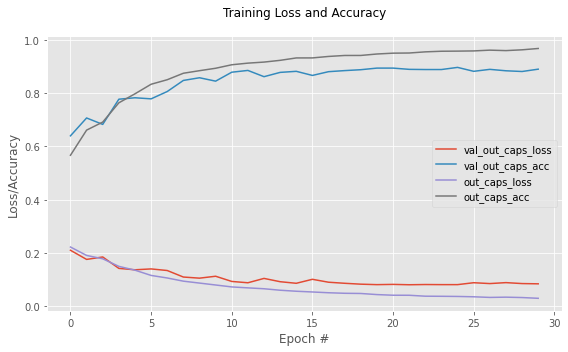


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.082    | 0.887    | 0.891     | 0.882    | 0.887   

-------------------------------
Testing with filter sizes 24/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 54s 4ms/step - loss: 0.4044 - out_caps_loss: 0.4043 - out_recon_loss: 0.0640 - out_caps_acc: 0.5011 - out_recon_acc: 0.1833 - val_loss: 0.4045 - val_out_caps_loss: 0.4045 - val_out_recon_loss: 0.0302 - val_out_caps_acc: 0.5081 - val_out_recon_acc: 0.2016
Epoch 2/30
13392/13392 [==============================] - 24s 2ms/step - loss: 0.4040 - out_caps_loss: 0.4040 - out_recon_loss: 0.0299 - out_caps_acc: 0.4937 - out_recon_acc: 0.2020 - val_loss: 0.4046 - val_out_caps_loss: 0.4046 - val_out_recon_loss: 0.0293 - val_out_caps_acc: 0.4919 - val_out_recon_acc: 0.2024
Epoch 00002: early stopping

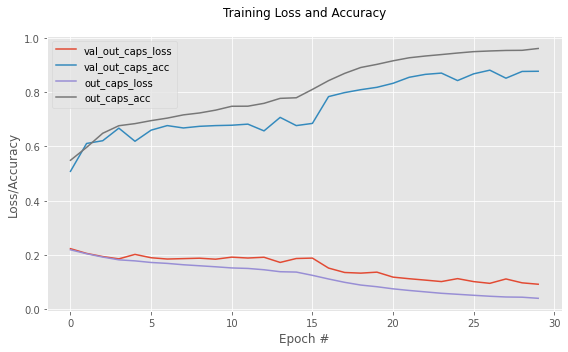


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.099    | 0.870    | 0.857     | 0.889    | 0.873   



In [0]:
flist=[[8,16],
       [16,32],
       [16,48],
       [24,48]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([5,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    es=True,
                                    pltFile="6_CapsnetModel_5.9_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

-------------------------------
Testing with filter sizes 8/16
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 43s 3ms/step - loss: 0.2205 - out_caps_loss: 0.2204 - out_recon_loss: 0.0695 - out_caps_acc: 0.5409 - out_recon_acc: 0.1843 - val_loss: 0.2090 - val_out_caps_loss: 0.2090 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.5598 - val_out_recon_acc: 0.2018
Epoch 2/30
13392/13392 [==============================] - 17s 1ms/step - loss: 0.2012 - out_caps_loss: 0.2011 - out_recon_loss: 0.0301 - out_caps_acc: 0.6149 - out_recon_acc: 0.2018 - val_loss: 0.2002 - val_out_caps_loss: 0.2001 - val_out_recon_loss: 0.0292 - val_out_caps_acc: 0.6573 - val_out_recon_acc: 0.2020
Epoch 3/30
13392/13392 [==============================] - 17s 1ms/step - loss: 0.1910 - out_caps_loss: 0.1909 - out_recon_loss: 0.0295 - out_caps_acc: 0.6540 - out_recon_acc: 0.2020 - val_loss: 0.1890 - val_out_caps_loss: 0.1889 -

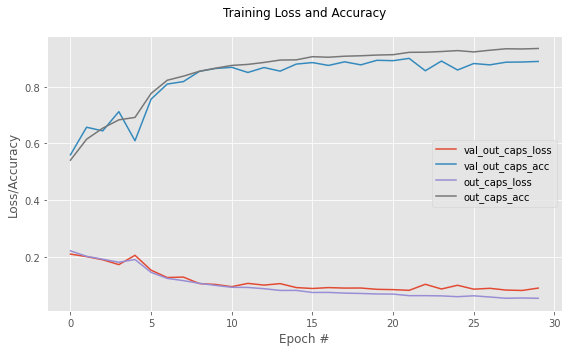


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.094    | 0.866    | 0.905     | 0.818    | 0.859   

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 47s 4ms/step - loss: 0.2220 - out_caps_loss: 0.2220 - out_recon_loss: 0.0706 - out_caps_acc: 0.5282 - out_recon_acc: 0.1854 - val_loss: 0.2052 - val_out_caps_loss: 0.2052 - val_out_recon_loss: 0.0370 - val_out_caps_acc: 0.6116 - val_out_recon_acc: 0.2022
Epoch 2/30
13392/13392 [==============================] - 20s 1ms/step - loss: 0.2048 - out_caps_loss: 0.2048 - out_recon_loss: 0.0303 - out_caps_acc: 0.6045 - out_recon_acc: 0.2019 - val_loss: 0.1970 - val_out_caps_loss: 0.1969 - val_out_recon_loss: 0.0292 - val_out_caps_acc: 0.6613 - val_out_recon_acc: 0.2019
Epoch 3/30
13392/13392 [===

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


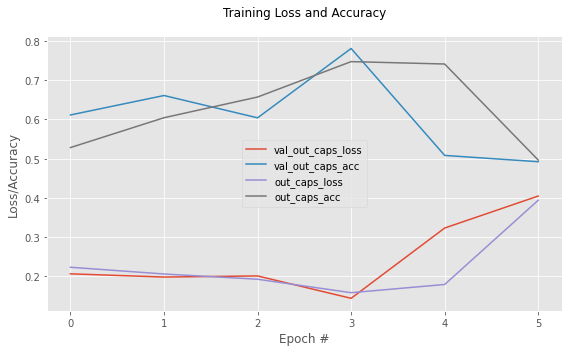


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.404    | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes 16/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 50s 4ms/step - loss: 0.2367 - out_caps_loss: 0.2366 - out_recon_loss: 0.0700 - out_caps_acc: 0.5329 - out_recon_acc: 0.1831 - val_loss: 0.2085 - val_out_caps_loss: 0.2085 - val_out_recon_loss: 0.0362 - val_out_caps_acc: 0.6022 - val_out_recon_acc: 0.2014
Epoch 2/30
13392/13392 [==============================] - 23s 2ms/step - loss: 0.2029 - out_caps_loss: 0.2029 - out_recon_loss: 0.0302 - out_caps_acc: 0.6057 - out_recon_acc: 0.2017 - val_loss: 0.1912 - val_out_caps_loss: 0.1912 - val_out_recon_loss: 0.0292 - val_out_caps_acc: 0.6405 - val_out_recon_acc: 0.2019
Epoch 3/30
13392/13392 [===

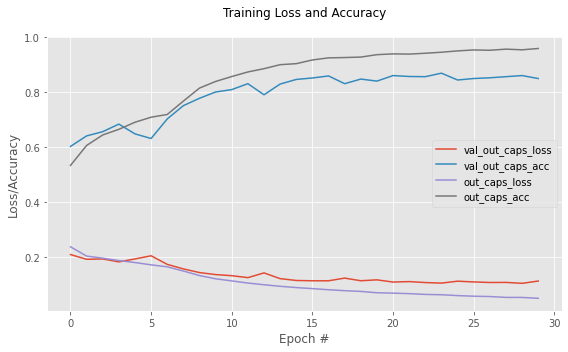


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.107    | 0.856    | 0.829     | 0.898    | 0.862   

-------------------------------
Testing with filter sizes 24/48
-------------------------------
Train on 13392 samples, validate on 1488 samples
Epoch 1/30
13392/13392 [==============================] - 50s 4ms/step - loss: 0.2228 - out_caps_loss: 0.2227 - out_recon_loss: 0.0720 - out_caps_acc: 0.5252 - out_recon_acc: 0.1844 - val_loss: 0.2154 - val_out_caps_loss: 0.2154 - val_out_recon_loss: 0.0454 - val_out_caps_acc: 0.5323 - val_out_recon_acc: 0.2028
Epoch 2/30
13392/13392 [==============================] - 22s 2ms/step - loss: 0.2075 - out_caps_loss: 0.2075 - out_recon_loss: 0.0310 - out_caps_acc: 0.5992 - out_recon_acc: 0.2018 - val_loss: 0.2046 - val_out_caps_loss: 0.2046 - val_out_recon_loss: 0.0292 - val_out_caps_acc: 0.6129 - val_out_recon_acc: 0.2017
Epoch 3/30
13392/13392 [===

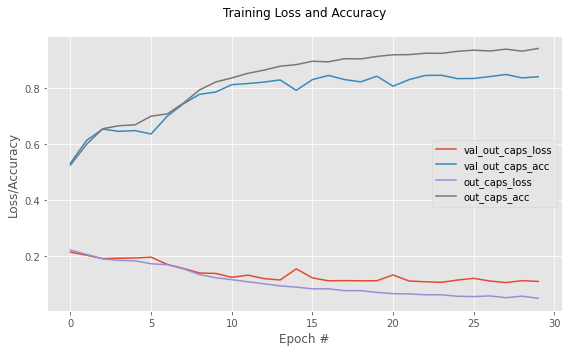


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.105    | 0.850    | 0.858     | 0.839    | 0.848   



In [0]:
flist=[[8,16],
       [16,32],
       [16,48],
       [24,48]]

for f_size in flist:
    print("-------------------------------")
    print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest([9,9], frac=60, bs=BATCH_SIZE, epochs=EPOCHS, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    es=True,
                                    pltFile="6_CapsnetModel_9.9_frac60_f{}.{}.png".format(f_size[0],f_size[1]))
    showScores(scores)
    print("")

#13 Test with all data

-------------------------------
Testing with filter sizes 4/8
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 34s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0667 - out_caps_acc: 0.4999 - out_recon_acc: 0.2016 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0387 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2021
Epoch 2/30
22321/22321 [==============================] - 30s 1ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0313 - out_caps_acc: 0.5000 - out_recon_acc: 0.2015 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2027
Epoch 00002: early stopping
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 35s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0297 - out_caps_acc: 0.5000 - out_recon_acc: 0.2016 - 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


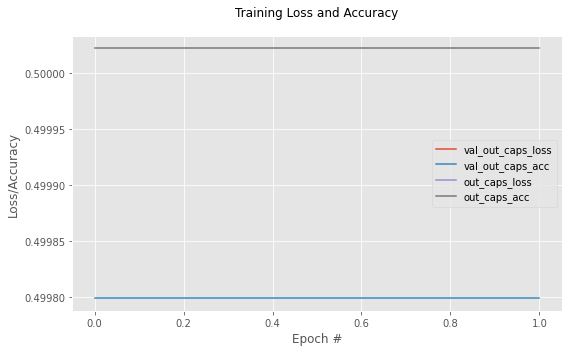


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores

-------------------------------
Testing with filter sizes 8/8
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 37s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0666 - out_caps_acc: 0.4999 - out_recon_acc: 0.2024 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0385 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2029
Epoch 2/30
22321/22321 [==============================] - 30s 1ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0313 - out_caps_acc: 0.5000 - out_recon_acc: 0.2016 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2025
Epoch 00002: early 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


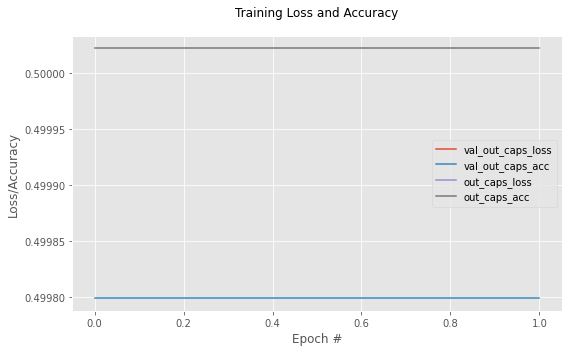


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores



In [0]:
flist=[[4,8], [8,8]]

for f_size in flist:
      print("-------------------------------")
      print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
      print("-------------------------------")
      (model, scores), hist = CapsTest([5,7], 
                                      frac=100, 
                                      bs=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      plot = True, 
                                      f_sizes=f_size,
                                      es=True,
                                      pltFile="6_CapsnetModel_5.7_frac100_f{}.{}.png".format(f_size[0],f_size[1]),
                                      bestFile="test_{}.{}.h5".format(f_size[0],f_size[1]))
      showScores(scores)

      print("")
      print("Best model (min val loss) scores")
      try:
          model.load_weights("test_{}.{}.h5".format(f_size[0],f_size[1]))
          showModelScores(model, test_X, test_Y)
      except:
          pass
      print("")  

-------------------------------
Testing with filter sizes 8/16
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 44s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0667 - out_caps_acc: 0.5000 - out_recon_acc: 0.2029 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0386 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2032
Epoch 2/30
22321/22321 [==============================] - 34s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0313 - out_caps_acc: 0.5000 - out_recon_acc: 0.2016 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2025
Epoch 00002: early stopping
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 43s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0297 - out_caps_acc: 0.5000 - out_recon_acc: 0.2016 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


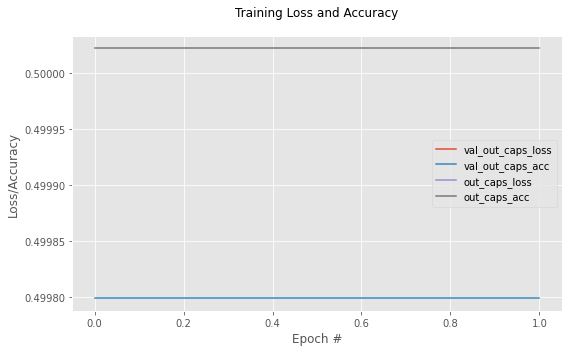


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 53s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0665 - out_caps_acc: 0.4998 - out_recon_acc: 0.2025 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0383 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2028
Epoch 2/30
22321/22321 [==============================] - 41s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0312 - out_caps_acc: 0.5000 - out_recon_acc: 0.2016 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2025
Epoch 00002: earl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


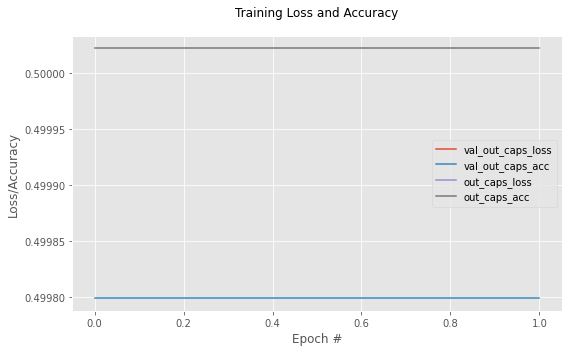


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores

-------------------------------
Testing with filter sizes 16/48
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 62s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0670 - out_caps_acc: 0.5001 - out_recon_acc: 0.2025 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0391 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2027
Epoch 2/30
22321/22321 [==============================] - 47s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0313 - out_caps_acc: 0.5000 - out_recon_acc: 0.2016 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2025
Epoch 00002: earl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


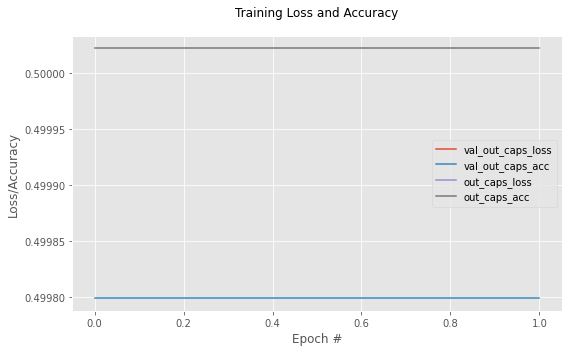


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores



In [0]:
flist=[[8,16],
       [16,32],
       [16, 48]]

for f_size in flist:
      print("-------------------------------")
      print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
      print("-------------------------------")
      (model, scores), hist = CapsTest([5,7], 
                                      frac=100, 
                                      bs=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      plot = True, 
                                      f_sizes=f_size,
                                      es=True,
                                      pltFile="6_CapsnetModel_5.7_frac100_f{}.{}.png".format(f_size[0],f_size[1]),
                                      bestFile="test_{}.{}.h5".format(f_size[0],f_size[1]))
      showScores(scores)

      print("")
      print("Best model (min val loss) scores")
      try:
          model.load_weights("test_{}.{}.h5".format(f_size[0],f_size[1]))
          showModelScores(model, test_X, test_Y)
      except:
          pass
      print("")  

-------------------------------
Testing with filter sizes 4/8
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 50s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0669 - out_caps_acc: 0.5000 - out_recon_acc: 0.2014 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0390 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2023
Epoch 2/30
22321/22321 [==============================] - 31s 1ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0313 - out_caps_acc: 0.5000 - out_recon_acc: 0.2015 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2026
Epoch 00002: early stopping
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 51s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0297 - out_caps_acc: 0.5000 - out_recon_acc: 0.2016 - 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


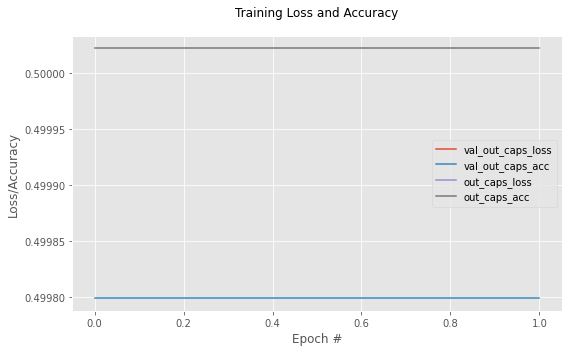


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores

-------------------------------
Testing with filter sizes 8/8
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 54s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0668 - out_caps_acc: 0.5002 - out_recon_acc: 0.2021 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0387 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2028
Epoch 2/30
22321/22321 [==============================] - 31s 1ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0313 - out_caps_acc: 0.5000 - out_recon_acc: 0.2016 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2025
Epoch 00002: early 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


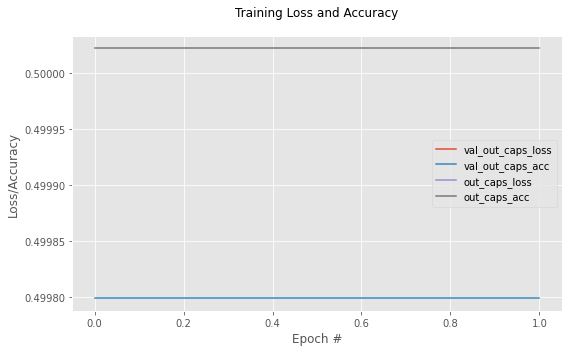


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores



In [0]:
flist=[[4,8], [8,8]]

for f_size in flist:
      print("-------------------------------")
      print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
      print("-------------------------------")
      (model, scores), hist = CapsTest([5,9], 
                                      frac=100, 
                                      bs=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      plot = True, 
                                      f_sizes=f_size,
                                      es=True,
                                      pltFile="6_CapsnetModel_5.9_frac100_f{}.{}.png".format(f_size[0],f_size[1]),
                                      bestFile="test_{}.{}.h5".format(f_size[0],f_size[1]))
      showScores(scores)

      print("")
      print("Best model (min val loss) scores")
      try:
          model.load_weights("test_{}.{}.h5".format(f_size[0],f_size[1]))
          showModelScores(model, test_X, test_Y)
      except:
          pass
      print("")  

-------------------------------
Testing with filter sizes 8/16
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 58s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0665 - out_caps_acc: 0.4999 - out_recon_acc: 0.2027 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0384 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2032
Epoch 2/30
22321/22321 [==============================] - 33s 1ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0312 - out_caps_acc: 0.5000 - out_recon_acc: 0.2017 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2025
Epoch 00002: early stopping
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 58s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0297 - out_caps_acc: 0.5000 - out_recon_acc: 0.2016 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


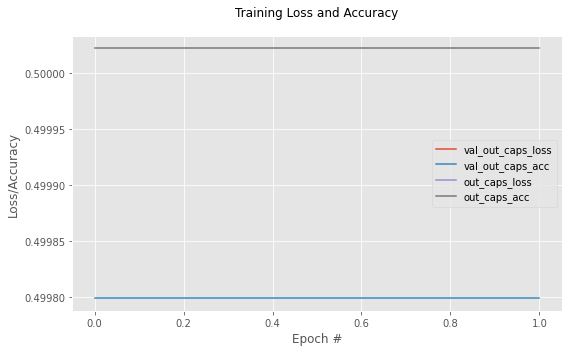


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 67s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0668 - out_caps_acc: 0.5001 - out_recon_acc: 0.2027 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0388 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2029
Epoch 2/30
22321/22321 [==============================] - 39s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0313 - out_caps_acc: 0.5000 - out_recon_acc: 0.2016 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2025
Epoch 00002: earl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


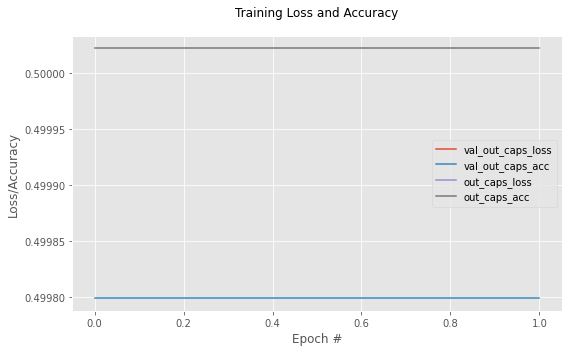


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores

-------------------------------
Testing with filter sizes 16/48
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 78s 3ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0666 - out_caps_acc: 0.5001 - out_recon_acc: 0.2027 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0385 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2034
Epoch 2/30
22321/22321 [==============================] - 47s 2ms/step - loss: nan - out_caps_loss: nan - out_recon_loss: 0.0313 - out_caps_acc: 0.5000 - out_recon_acc: 0.2017 - val_loss: nan - val_out_caps_loss: nan - val_out_recon_loss: 0.0304 - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.2025
Epoch 00002: earl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


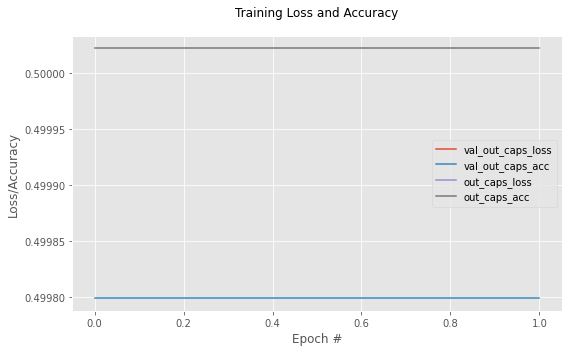


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores



In [0]:
flist=[[8,16],
       [16,32],
       [16, 48]]

for f_size in flist:
      print("-------------------------------")
      print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
      print("-------------------------------")
      (model, scores), hist = CapsTest([5,9], 
                                      frac=100, 
                                      bs=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      plot = True, 
                                      f_sizes=f_size,
                                      es=True,
                                      pltFile="6_CapsnetModel_5.9_frac100_f{}.{}.png".format(f_size[0],f_size[1]),
                                      bestFile="test_{}.{}.h5".format(f_size[0],f_size[1]))
      showScores(scores)

      print("")
      print("Best model (min val loss) scores")
      try:
          model.load_weights("test_{}.{}.h5".format(f_size[0],f_size[1]))
          showModelScores(model, test_X, test_Y)
      except:
          pass
      print("")  

-------------------------------
Testing with filter sizes 4/8
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 66s 3ms/step - loss: 0.2095 - out_caps_loss: 0.2095 - out_recon_loss: 0.0539 - out_caps_acc: 0.5810 - out_recon_acc: 0.1922 - val_loss: 0.1775 - val_out_caps_loss: 0.1774 - val_out_recon_loss: 0.0301 - val_out_caps_acc: 0.7102 - val_out_recon_acc: 0.2026
Epoch 2/30
22321/22321 [==============================] - 31s 1ms/step - loss: 0.1739 - out_caps_loss: 0.1739 - out_recon_loss: 0.0294 - out_caps_acc: 0.7087 - out_recon_acc: 0.2015 - val_loss: 0.1619 - val_out_caps_loss: 0.1619 - val_out_recon_loss: 0.0299 - val_out_caps_acc: 0.7650 - val_out_recon_acc: 0.2031
Epoch 3/30
22321/22321 [==============================] - 31s 1ms/step - loss: 0.1538 - out_caps_loss: 0.1538 - out_recon_loss: 0.0292 - out_caps_acc: 0.7643 - out_recon_acc: 0.2020 - val_loss: 0.1599 - val_out_caps_loss: 0.1599 - 

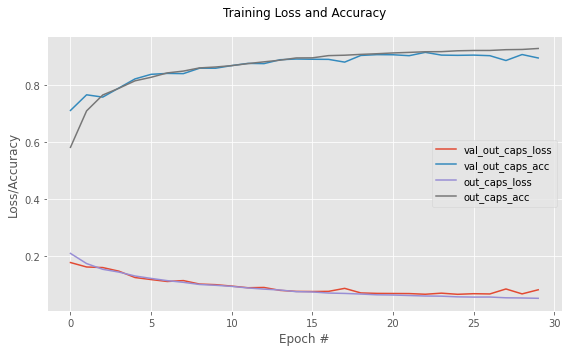


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.080    | 0.898    | 0.869     | 0.937    | 0.902   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.065    | 0.911    | 0.922     | 0.898    | 0.910   

-------------------------------
Testing with filter sizes 8/8
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 66s 3ms/step - loss: 0.2207 - out_caps_loss: 0.2206 - out_recon_loss: 0.0537 - out_caps_acc: 0.5453 - out_recon_acc: 0.1903 - val_loss: 0.2085 - val_out_caps_loss: 0.2085 - val_out_recon_loss: 0.0301 - val_out_caps_acc: 0.5945 - val_out_recon_acc: 0.2026
Epoch 2/30
22321/22321 [==============================] - 31s 1ms/step - loss: 0.1985 - out_caps_loss: 0.19

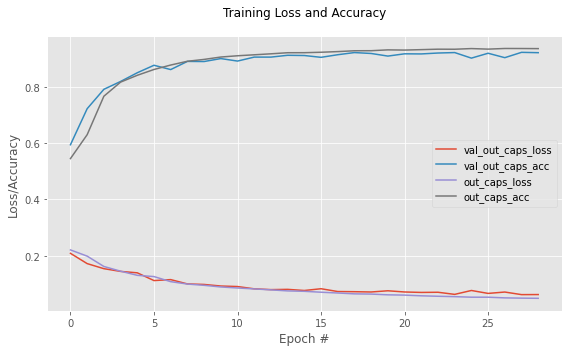


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.063    | 0.920    | 0.967     | 0.869    | 0.916   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.059    | 0.922    | 0.936     | 0.906    | 0.921   



In [0]:
flist=[[4,8], [8,8]]

for f_size in flist:
      print("-------------------------------")
      print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
      print("-------------------------------")
      (model, scores), hist = CapsTest([9,9], 
                                      frac=100, 
                                      bs=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      plot = True, 
                                      f_sizes=f_size,
                                      es=True,
                                      pltFile="6_CapsnetModel_9.9_frac100_f{}.{}.png".format(f_size[0],f_size[1]),
                                      bestFile="test_{}.{}.h5".format(f_size[0],f_size[1]))
      showScores(scores)

      print("")
      print("Best model (min val loss) scores")
      try:
          model.load_weights("test_{}.{}.h5".format(f_size[0],f_size[1]))
          showModelScores(model, test_X, test_Y)
      except:
          pass
      print("")  

-------------------------------
Testing with filter sizes 8/16
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 68s 3ms/step - loss: 0.2144 - out_caps_loss: 0.2144 - out_recon_loss: 0.0524 - out_caps_acc: 0.5663 - out_recon_acc: 0.1916 - val_loss: 0.1894 - val_out_caps_loss: 0.1894 - val_out_recon_loss: 0.0302 - val_out_caps_acc: 0.6663 - val_out_recon_acc: 0.2027
Epoch 2/30
22321/22321 [==============================] - 32s 1ms/step - loss: 0.1847 - out_caps_loss: 0.1847 - out_recon_loss: 0.0295 - out_caps_acc: 0.6788 - out_recon_acc: 0.2015 - val_loss: 0.1530 - val_out_caps_loss: 0.1530 - val_out_recon_loss: 0.0299 - val_out_caps_acc: 0.7521 - val_out_recon_acc: 0.2027
Epoch 3/30
22321/22321 [==============================] - 32s 1ms/step - loss: 0.1477 - out_caps_loss: 0.1477 - out_recon_loss: 0.0293 - out_caps_acc: 0.7733 - out_recon_acc: 0.2016 - val_loss: 0.1342 - val_out_caps_loss: 0.1342 -

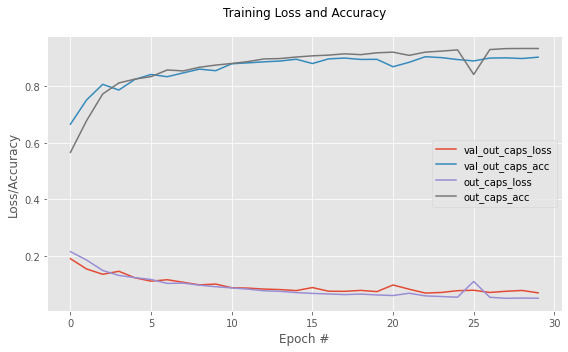


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.068    | 0.908    | 0.903     | 0.914    | 0.909   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.067    | 0.910    | 0.937     | 0.880    | 0.907   

-------------------------------
Testing with filter sizes 16/32
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 72s 3ms/step - loss: 0.2170 - out_caps_loss: 0.2169 - out_recon_loss: 0.0538 - out_caps_acc: 0.5450 - out_recon_acc: 0.1907 - val_loss: 0.1934 - val_out_caps_loss: 0.1934 - val_out_recon_loss: 0.0301 - val_out_caps_acc: 0.6368 - val_out_recon_acc: 0.2026
Epoch 2/30
22321/22321 [==============================] - 37s 2ms/step - loss: 0.1971 - out_caps_loss: 0.

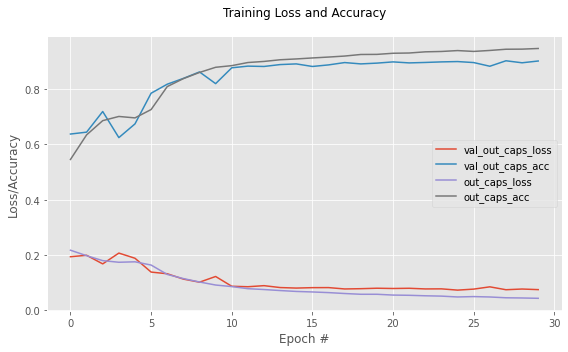


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.072    | 0.905    | 0.895     | 0.919    | 0.907   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.068    | 0.907    | 0.910     | 0.905    | 0.907   

-------------------------------
Testing with filter sizes 16/48
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 78s 4ms/step - loss: 0.2169 - out_caps_loss: 0.2169 - out_recon_loss: 0.0539 - out_caps_acc: 0.5552 - out_recon_acc: 0.1907 - val_loss: 0.2046 - val_out_caps_loss: 0.2045 - val_out_recon_loss: 0.0302 - val_out_caps_acc: 0.6046 - val_out_recon_acc: 0.2024
Epoch 2/30
22321/22321 [==============================] - 42s 2ms/step - loss: 0.1961 - out_caps_loss: 0.

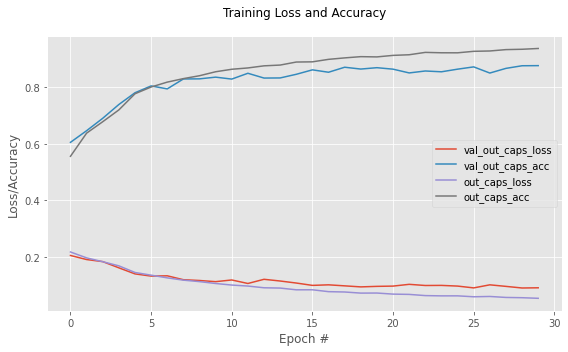


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.086    | 0.883    | 0.864     | 0.909    | 0.886   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.086    | 0.879    | 0.887     | 0.869    | 0.878   



In [0]:
flist=[[8,16],
       [16,32],
       [16, 48]]

for f_size in flist:
      print("-------------------------------")
      print("Testing with filter sizes {}/{}".format(f_size[0],f_size[1]))
      print("-------------------------------")
      (model, scores), hist = CapsTest([9,9], 
                                      frac=100, 
                                      bs=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      plot = True, 
                                      f_sizes=f_size,
                                      es=False,
                                      pltFile="6_CapsnetModel_9.9_frac100_f{}.{}.png".format(f_size[0],f_size[1]),
                                      bestFile="test_{}.{}.h5".format(f_size[0],f_size[1]))
      showScores(scores)

      print("")
      print("Best model (min val loss) scores")
      try:
          model.load_weights("test_{}.{}.h5".format(f_size[0],f_size[1]))
          showModelScores(model, test_X, test_Y)
      except:
          pass
      print("")  

##14 Save models and images

In [0]:
%%bash
cp -f ./*.h5 "$GPATH/Models"
cp -f ./*.json "$GPATH/Models"
cp -f ./*.png "$GPATH/Images"

cp: cannot stat './*.json': No such file or directory
